<a href="https://colab.research.google.com/github/stiwari-ds/data-science-competitions/blob/main/dphi/ds93/notebooks/01_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [55]:
%%capture
!pip install -U optuna

In [56]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
optuna.logging.set_verbosity(optuna.logging.ERROR)

optuna.__version__

'3.0.3'

In [58]:
import gc
import os
import time
import warnings

gc.enable()
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [2]:
SEED = 130322
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [3]:
DATA_URL = 'https://raw.githubusercontent.com/stiwari-ds/data-science-competitions/main/dphi/ds93/data'

train = pd.read_csv(f'{DATA_URL}/raw/train_dataset.csv')
test = pd.read_csv(f'{DATA_URL}/raw/test_dataset.csv')

# Data Overview

In [4]:
train.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,69892,1052.973,389.8558,228.6715,1.7049,0.8099,71139,298.3107,0.6843,0.9825,0.7921,0.7652,0.0056,0.0012,0.5855,0.9982,BARBUNYA
1,34584,704.813,272.4484,161.9722,1.6821,0.8041,34940,209.8421,0.6782,0.9898,0.8749,0.7702,0.0079,0.0017,0.5932,0.9978,DERMASON
2,72102,1072.061,377.6167,243.5039,1.5508,0.7643,73400,302.9903,0.7085,0.9823,0.7883,0.8024,0.0052,0.0013,0.6438,0.9984,BARBUNYA
3,207673,1755.004,659.2733,405.1693,1.6272,0.7889,210788,514.2154,0.7337,0.9852,0.8473,0.7800,0.0032,0.0007,0.6084,0.9899,BOMBAY
4,200116,1773.379,636.1081,402.3251,1.5811,0.7746,202634,504.7728,0.7734,0.9876,0.7996,0.7935,0.0032,0.0008,0.6297,0.9956,BOMBAY


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             2500 non-null   int64  
 1   Perimeter        2500 non-null   float64
 2   MajorAxisLength  2500 non-null   float64
 3   MinorAxisLength  2500 non-null   float64
 4   AspectRation     2500 non-null   float64
 5   Eccentricity     2500 non-null   float64
 6   ConvexArea       2500 non-null   int64  
 7   EquivDiameter    2500 non-null   float64
 8   Extent           2500 non-null   float64
 9   Solidity         2500 non-null   float64
 10  roundness        2500 non-null   float64
 11  Compactness      2500 non-null   float64
 12  ShapeFactor1     2500 non-null   float64
 13  ShapeFactor2     2500 non-null   float64
 14  ShapeFactor3     2500 non-null   float64
 15  ShapeFactor4     2500 non-null   float64
 16  Class            2500 non-null   object 
dtypes: float64(14)

In [6]:
TARGET = 'Class'

In [7]:
train[TARGET].value_counts(normalize=True)

DERMASON    0.2616
SIRA        0.1920
SEKER       0.1496
HOROZ       0.1444
CALI        0.1104
BARBUNYA    0.1008
BOMBAY      0.0412
Name: Class, dtype: float64

# Feature exploration

### Utility functions

In [16]:
def plot_cont(feature):
    """Plot side-by-side kdeplots for train and test
    data distribution of continuous feature.
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 3))
    plt.suptitle(f'Feature: {feature}', fontweight='bold')
    sns.kdeplot(x=feature, data=train, ax=ax[0], cut=0)
    ax[0].set_title('Train data')
    ax[0].minorticks_on()
    sns.kdeplot(x=feature, data=test, ax=ax[1], cut=0)
    ax[1].set_title('Test data')
    ax[1].minorticks_on()
    fig.tight_layout()
    plt.show()

In [17]:
def plot_cont_vs_target(feature):
    """Plot kdeplot for distribution of continuous feature
    split by categories of Target variable.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
    plt.suptitle(f'{feature} vs. {TARGET}', fontweight='bold')
    ax.minorticks_on()
    sns.kdeplot(x=feature, data=train, hue=TARGET, ax=ax, cut=0)
    fig.tight_layout()
    plt.show()

In [10]:
def explore_cont(feature):
    #Feature distribution 
    describe_df = pd.DataFrame()
    describe_df.index = train[feature].describe().index
    describe_df['Train'] = train[feature].describe().values
    describe_df['Test'] = test[feature].describe().values
    print('\nFeature distribution:')
    display(describe_df.T)
    plot_cont(feature)
    #Feature distribution grouped by target class
    print(f'\nFeature distribution vs target variable:')
    display(train.groupby(TARGET)[feature].describe())
    plot_cont_vs_target(feature)

### Features

**Area**


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,2500.0,53313.7004,30159.1328,21348.0,36417.75,44751.0,61028.75,254616.0
Test,2500.0,53289.4428,29602.4736,20711.0,36442.50,44871.0,60822.25,241322.0


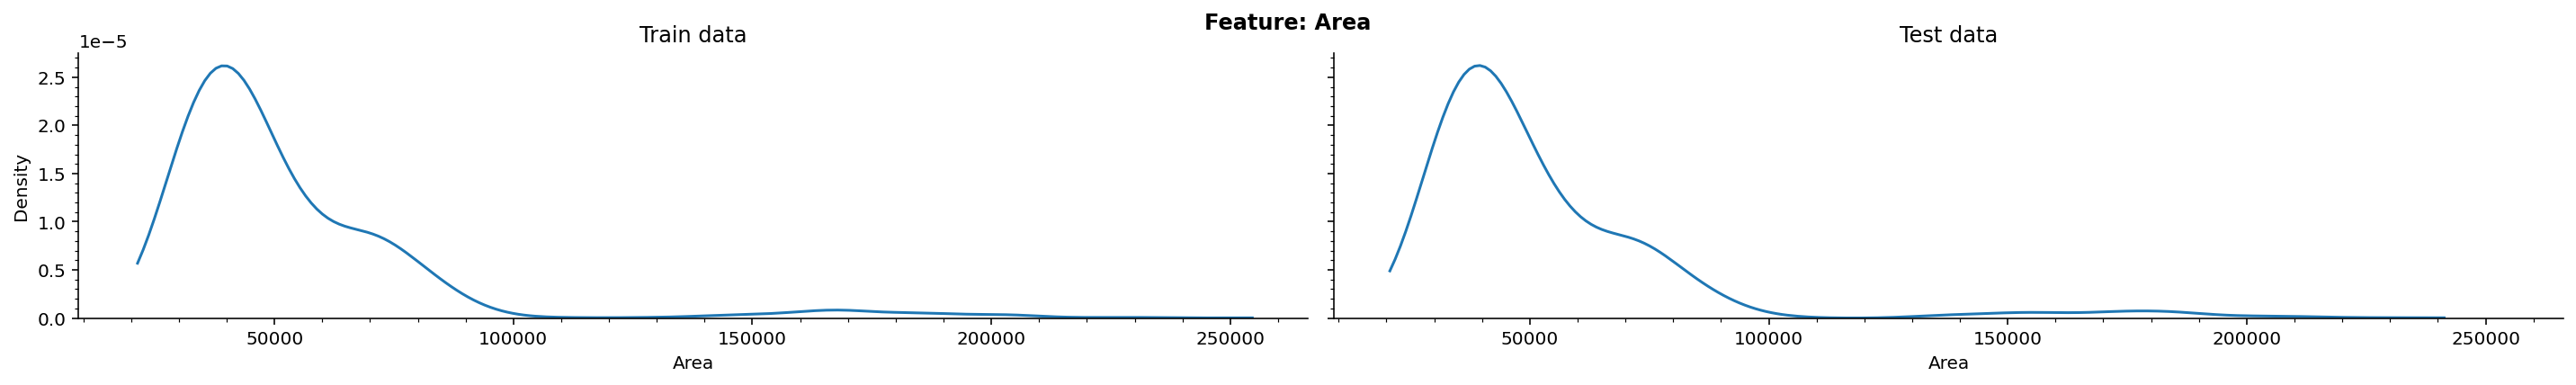


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
BARBUNYA,252.0,69602.7817,10280.7560,41487.0,62416.25,69511.5,76239.50,98277.0
BOMBAY,103.0,174939.1068,23913.1289,114004.0,160302.00,171028.0,188498.50,254616.0
CALI,276.0,75167.5109,8861.3568,45666.0,69597.25,74454.0,81647.25,107911.0
DERMASON,654.0,32179.8211,4546.4314,21348.0,28835.00,31832.5,35541.50,42097.0
HOROZ,361.0,53952.0997,7243.9471,35464.0,48650.00,54130.0,58646.00,72012.0
SEKER,374.0,39888.4652,4653.2710,30140.0,36571.25,39131.5,43027.25,57994.0
SIRA,480.0,44872.4833,4549.9375,33180.0,41939.25,44694.0,47695.00,57436.0


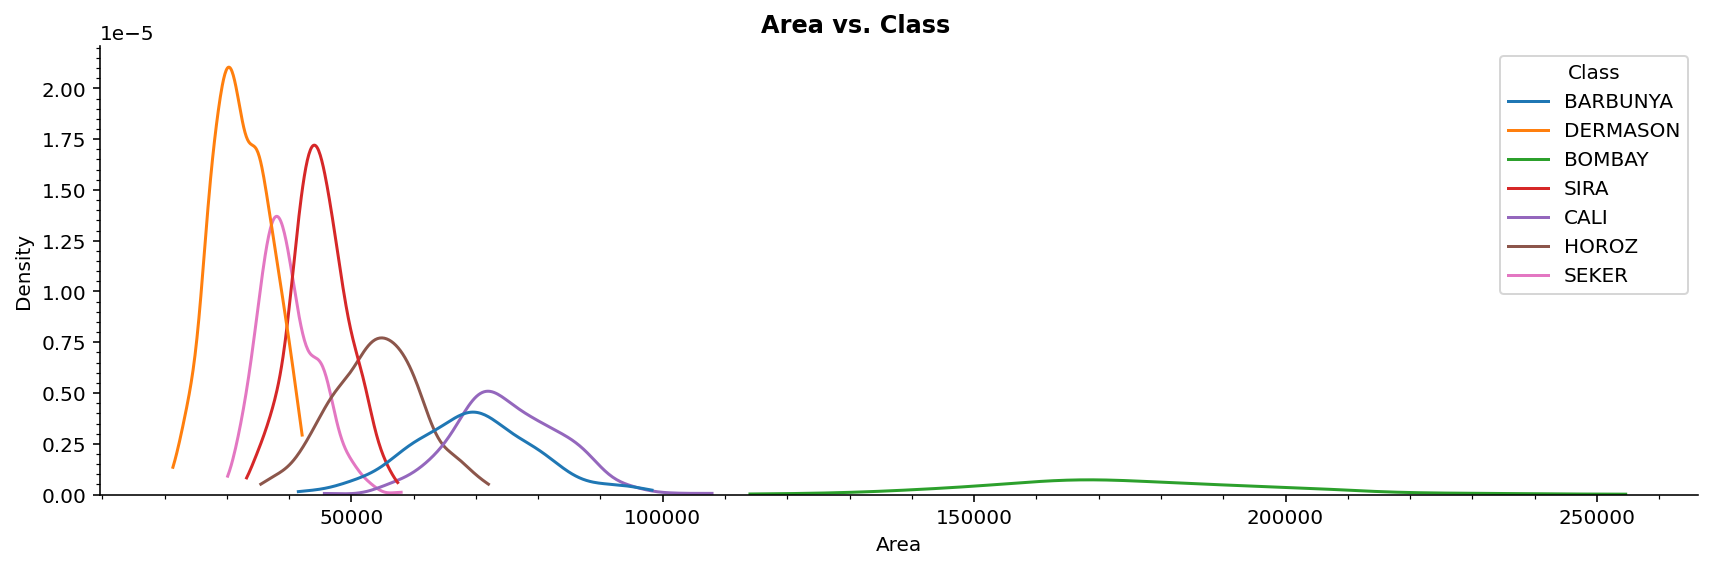

In [18]:
explore_cont('Area')

**Perimeter**


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,2500.0,856.8975,217.8717,530.825,702.8140,794.9690,977.5018,1985.37
Test,2500.0,857.1095,215.4978,525.413,704.3682,794.5965,973.5635,1895.94


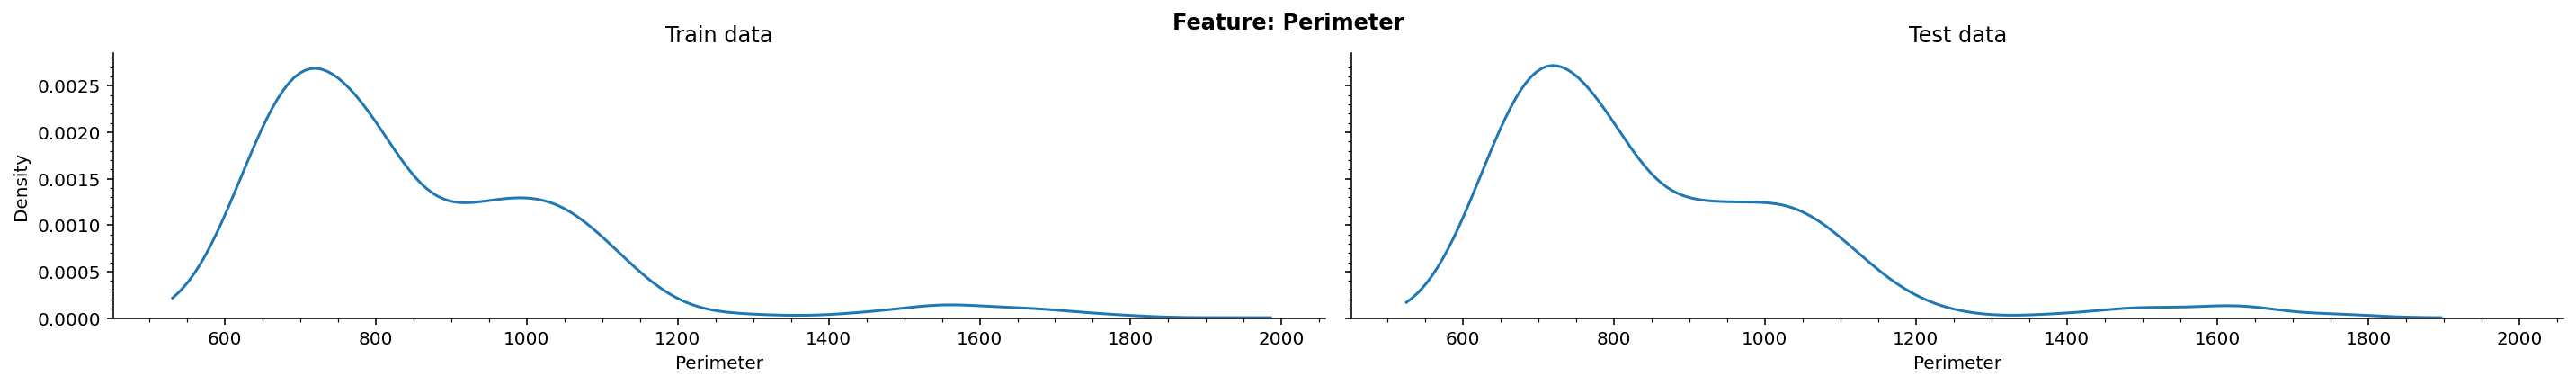


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
BARBUNYA,252.0,1045.4316,91.9112,799.426,987.0008,1049.1790,1095.9905,1338.893
BOMBAY,103.0,1591.0983,118.5691,1279.356,1525.9180,1578.4180,1664.4830,1985.370
CALI,276.0,1055.6256,65.9337,789.770,1014.1558,1051.3665,1102.4803,1298.822
DERMASON,654.0,665.6371,49.0623,530.825,631.2332,663.6700,702.0297,793.483
HOROZ,361.0,923.9199,67.5041,727.659,884.3080,927.3760,968.5530,1158.389
SEKER,374.0,727.6558,46.8093,620.134,696.7498,719.8050,758.6830,925.731
SIRA,480.0,796.9879,44.4986,670.488,768.9970,795.0275,825.6355,932.171


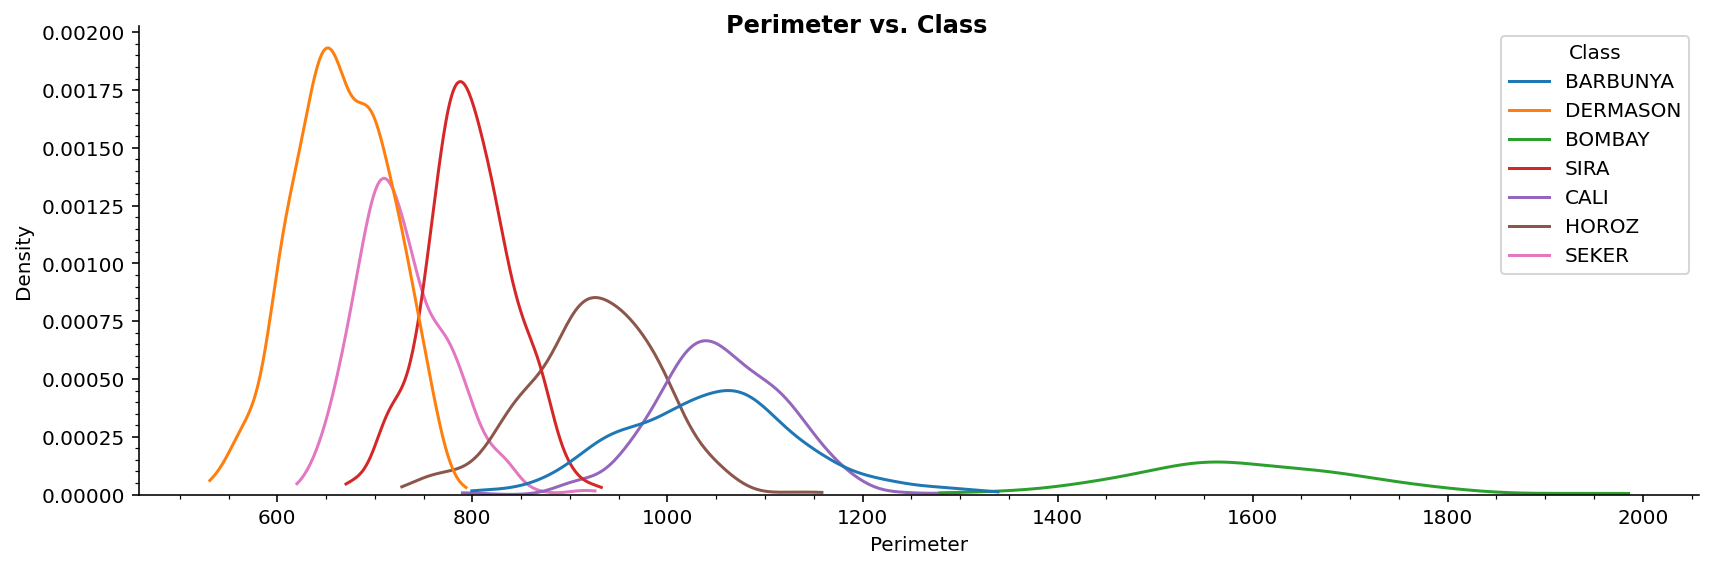

In [20]:
explore_cont('Perimeter')

**MajorAxisLength**


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,2500.0,320.6136,86.5532,187.1686,252.9023,296.498,376.4937,738.8602
Test,2500.0,320.7122,85.7061,186.0791,253.8766,297.683,376.5890,726.3735


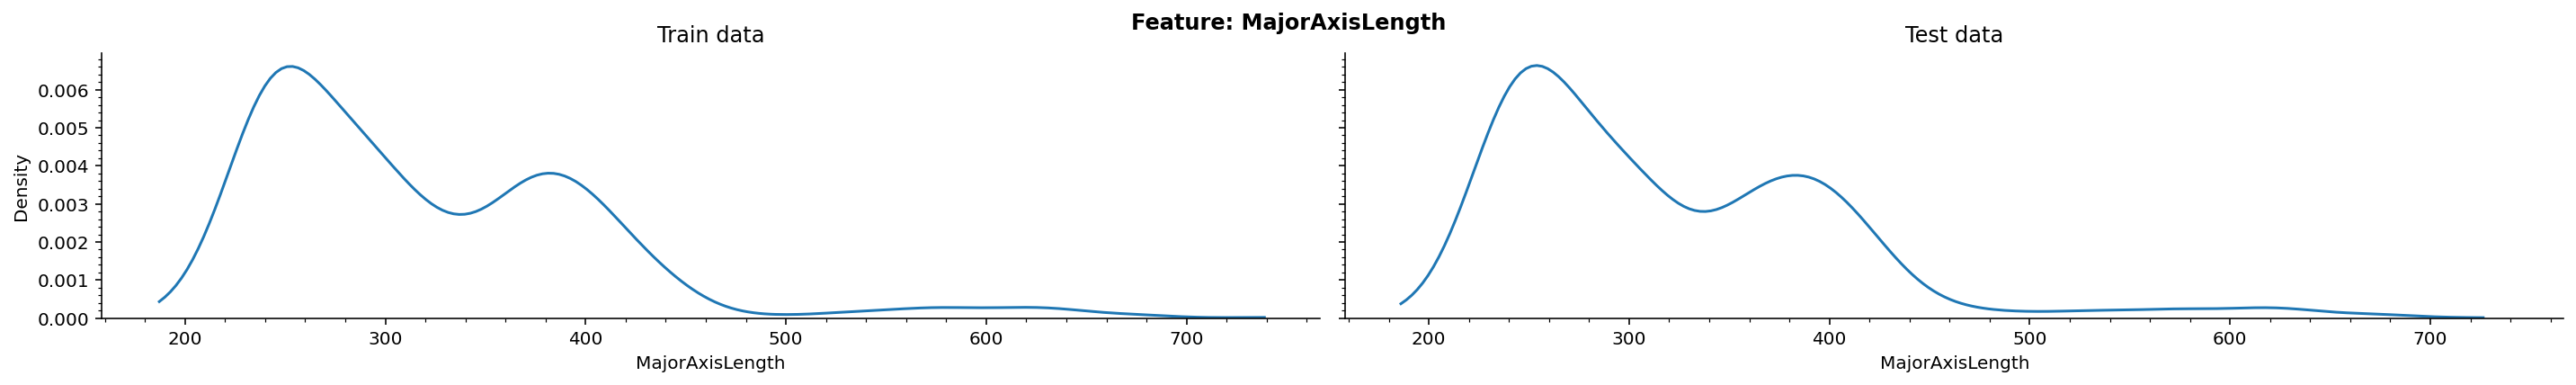


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
BARBUNYA,252.0,371.1708,31.7781,273.4029,350.6650,372.9813,391.8211,451.4417
BOMBAY,103.0,593.8546,53.0986,451.3613,563.4732,593.2555,628.6921,738.8602
CALI,276.0,408.5953,28.8321,274.8634,390.1371,408.8230,429.1052,498.5978
DERMASON,654.0,247.0346,20.4007,187.1686,233.3666,245.9347,262.2413,302.3224
HOROZ,361.0,373.5376,29.0979,271.1585,356.8421,374.9939,392.3739,446.7296
SEKER,374.0,251.5021,19.4336,201.8479,238.4491,249.0398,263.3352,339.9315
SIRA,480.0,299.1461,20.6388,240.3770,285.8048,298.0793,312.3242,361.6974


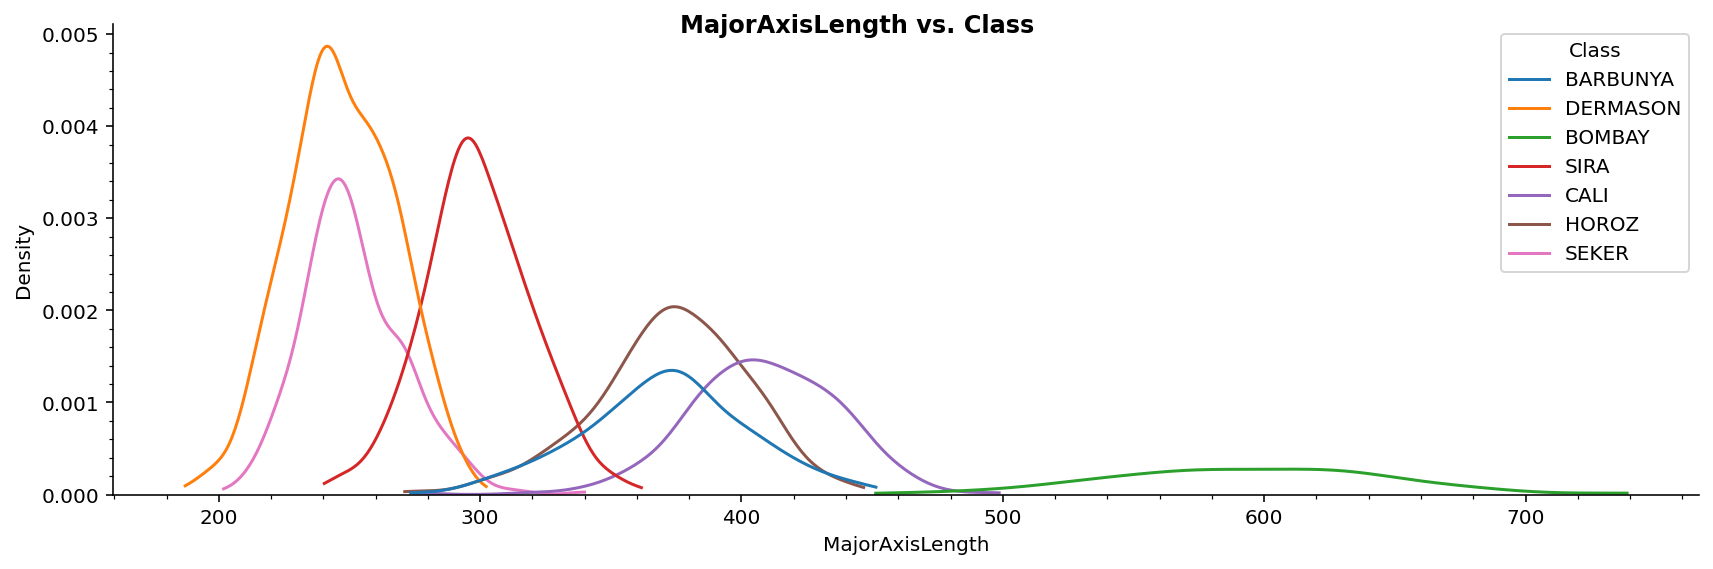

In [21]:
explore_cont('MajorAxisLength')

**MinorAxisLength**


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,2500.0,202.6564,46.0162,131.4331,175.6673,192.8379,216.1716,460.1985
Test,2500.0,202.7198,45.7824,122.5127,175.3642,192.0577,217.5207,440.6864


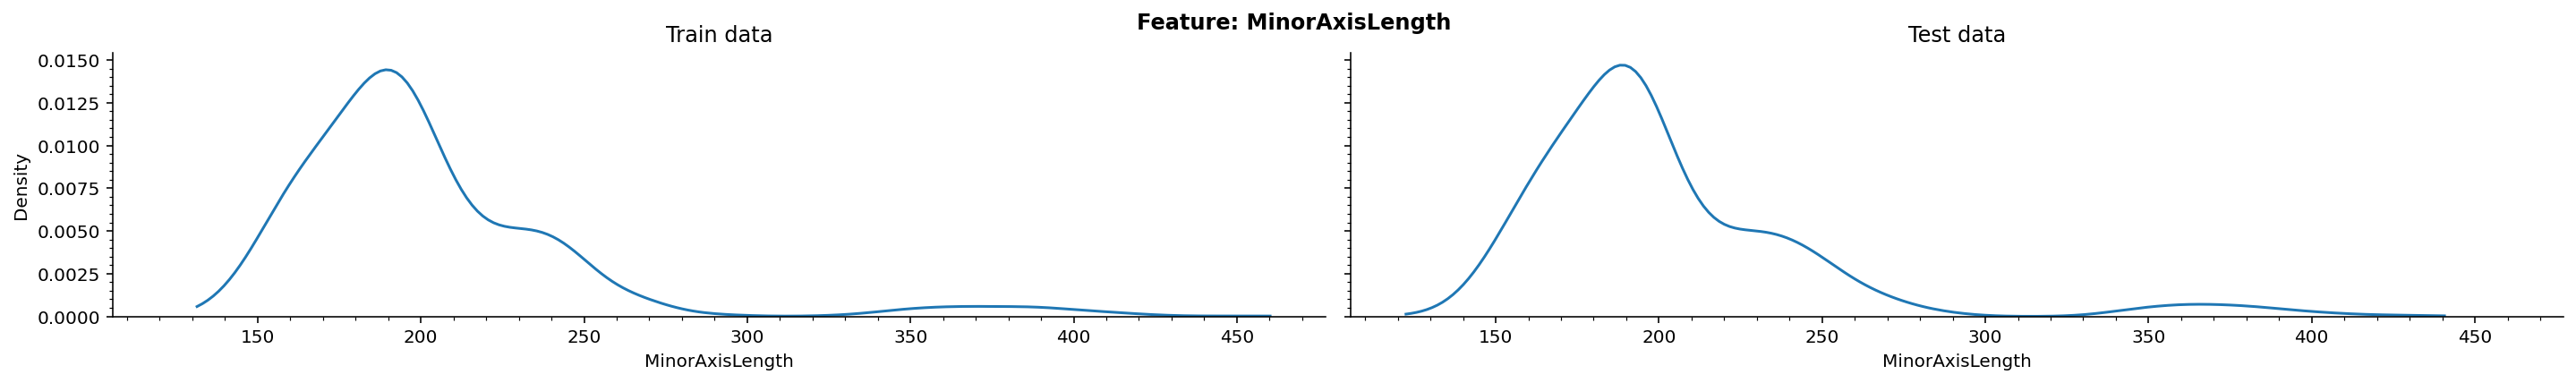


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
BARBUNYA,252.0,238.8359,19.8029,177.0815,226.5503,238.9929,249.9218,295.7132
BOMBAY,103.0,376.8935,24.8294,323.7480,357.5453,374.0466,391.0403,460.1985
CALI,276.0,235.7651,13.9253,194.0923,225.9817,235.6161,244.5646,279.3503
DERMASON,654.0,165.6908,12.0585,131.4331,156.5776,165.6391,174.5815,198.3008
HOROZ,361.0,184.9151,14.2618,149.3573,174.9727,184.0816,194.2770,237.8999
SEKER,374.0,201.7861,10.7241,177.1582,193.8450,200.2406,209.4067,241.0509
SIRA,480.0,191.6228,9.2008,165.2836,185.8369,192.0455,197.9368,224.7293


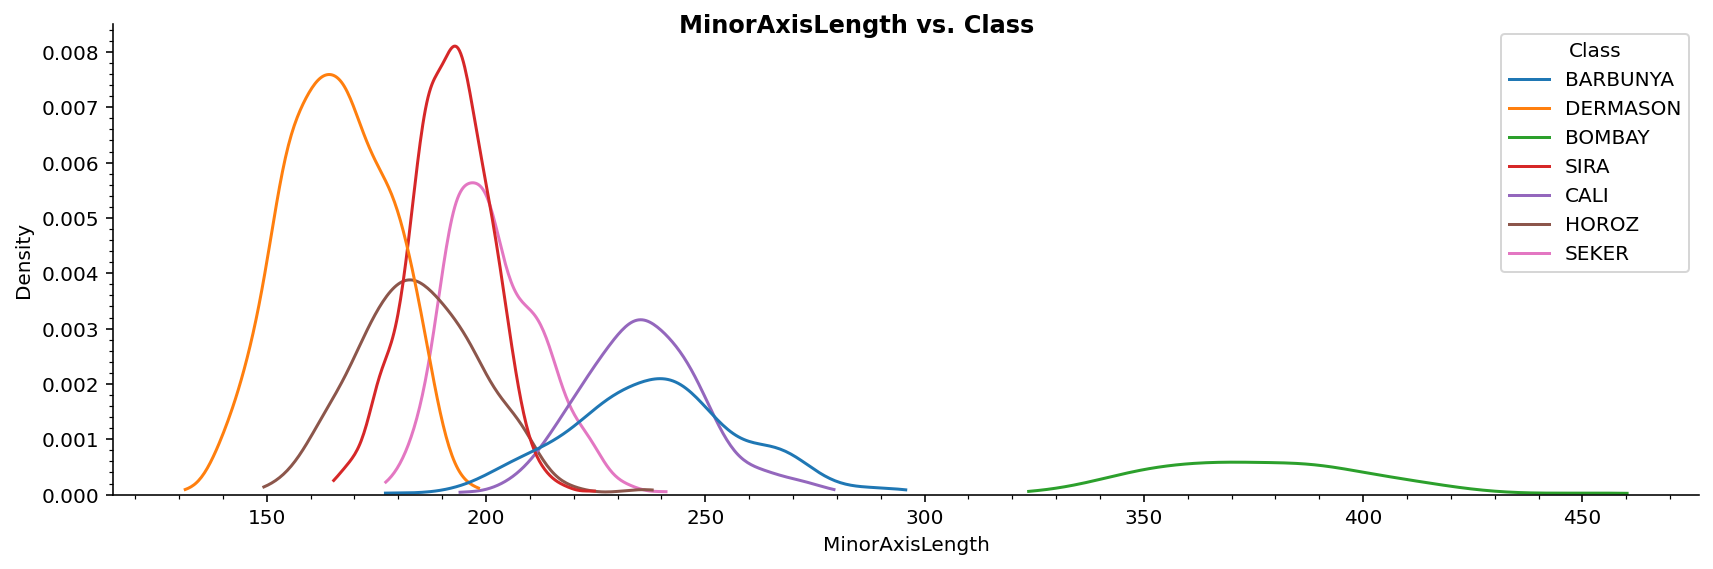

In [22]:
explore_cont('MinorAxisLength')

**AspectRation**


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,2500.0,1.5829,0.2471,1.0608,1.4322,1.5494,1.7047,2.3640
Test,2500.0,1.5839,0.2480,1.0492,1.4298,1.5529,1.7071,2.4303


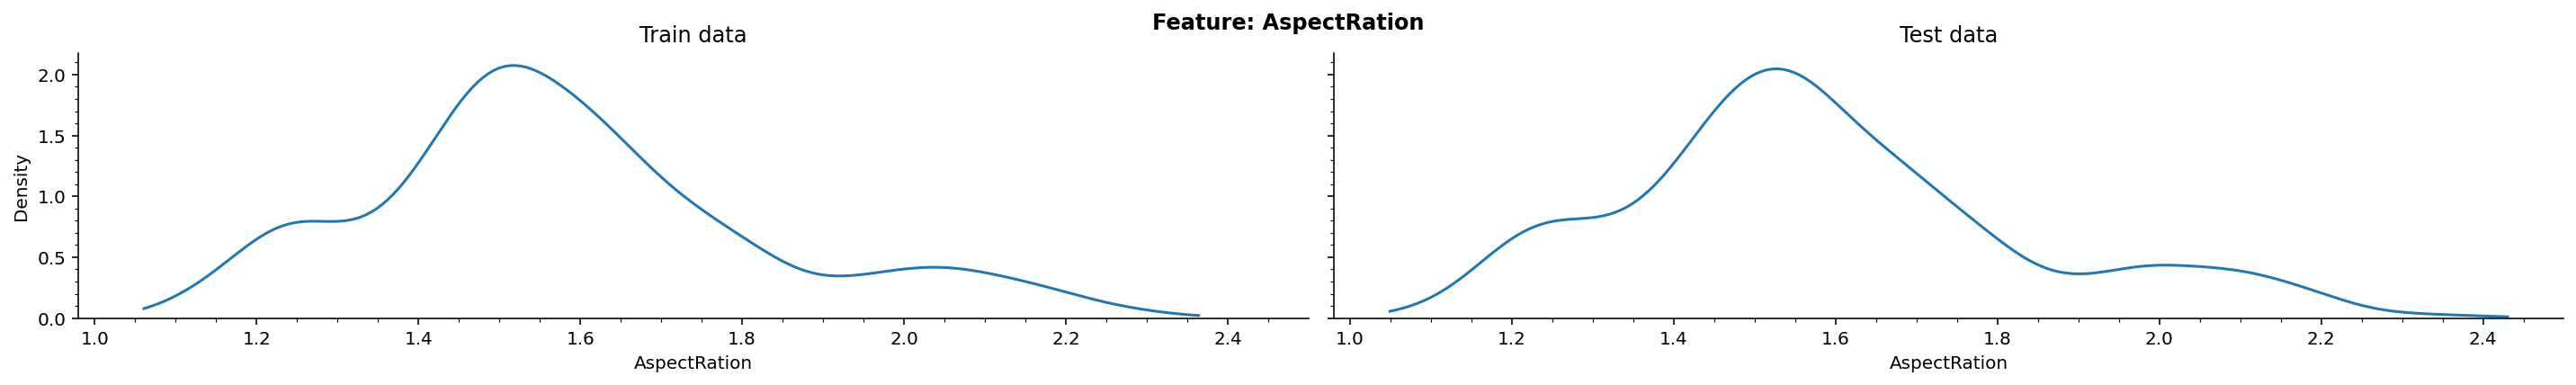


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
BARBUNYA,252.0,1.5584,0.1219,1.2136,1.4762,1.5576,1.6513,1.9504
BOMBAY,103.0,1.5773,0.1206,1.2396,1.4796,1.5804,1.6515,1.8716
CALI,276.0,1.7343,0.0951,1.2972,1.6699,1.7383,1.7983,1.9764
DERMASON,654.0,1.4928,0.0958,1.2253,1.4305,1.4874,1.5524,1.8057
HOROZ,361.0,2.0249,0.1433,1.5336,1.9467,2.0400,2.1227,2.3640
SEKER,374.0,1.2470,0.0804,1.0608,1.1998,1.2390,1.2831,1.5631
SIRA,480.0,1.5621,0.0955,1.2593,1.4955,1.5567,1.6214,1.8544


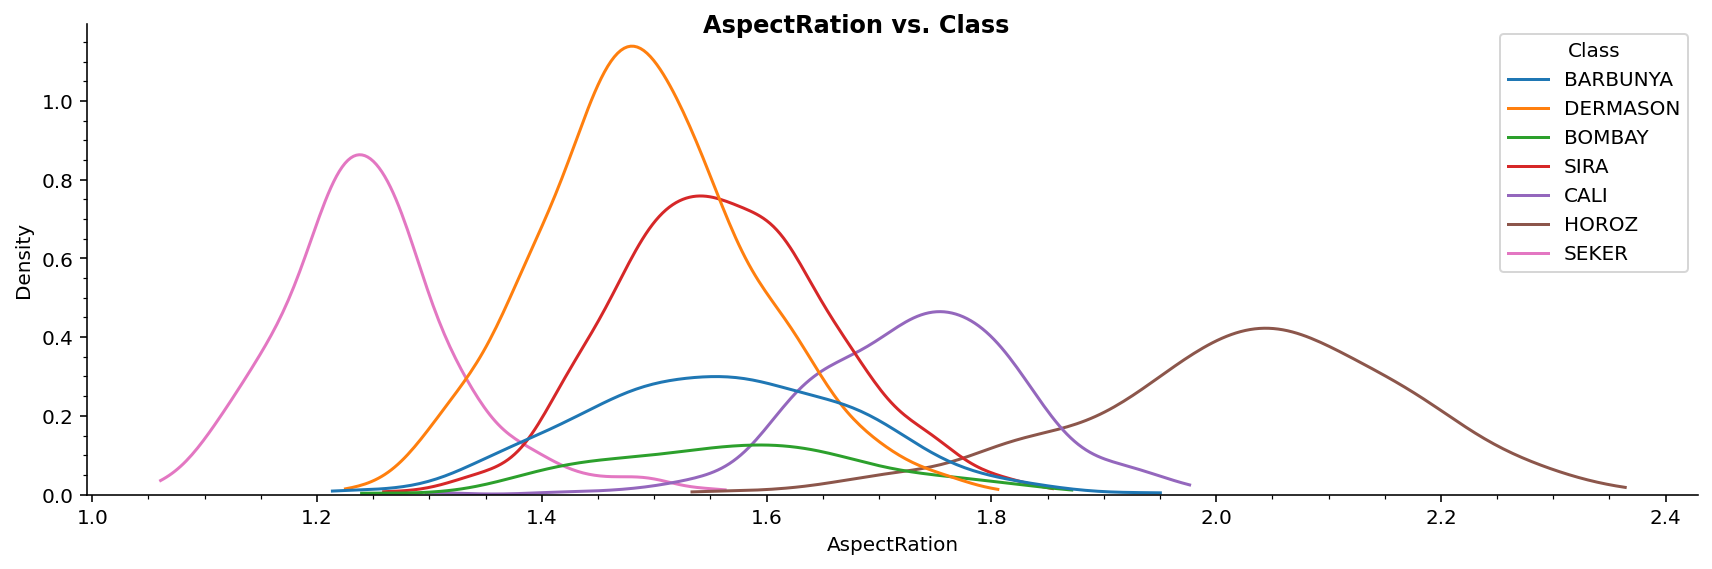

In [23]:
explore_cont('AspectRation')

**Eccentricity**


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,2500.0,0.7510,0.0911,0.3337,0.7159,0.7638,0.8099,0.9061
Test,2500.0,0.7511,0.0914,0.3026,0.7147,0.7651,0.8105,0.9114


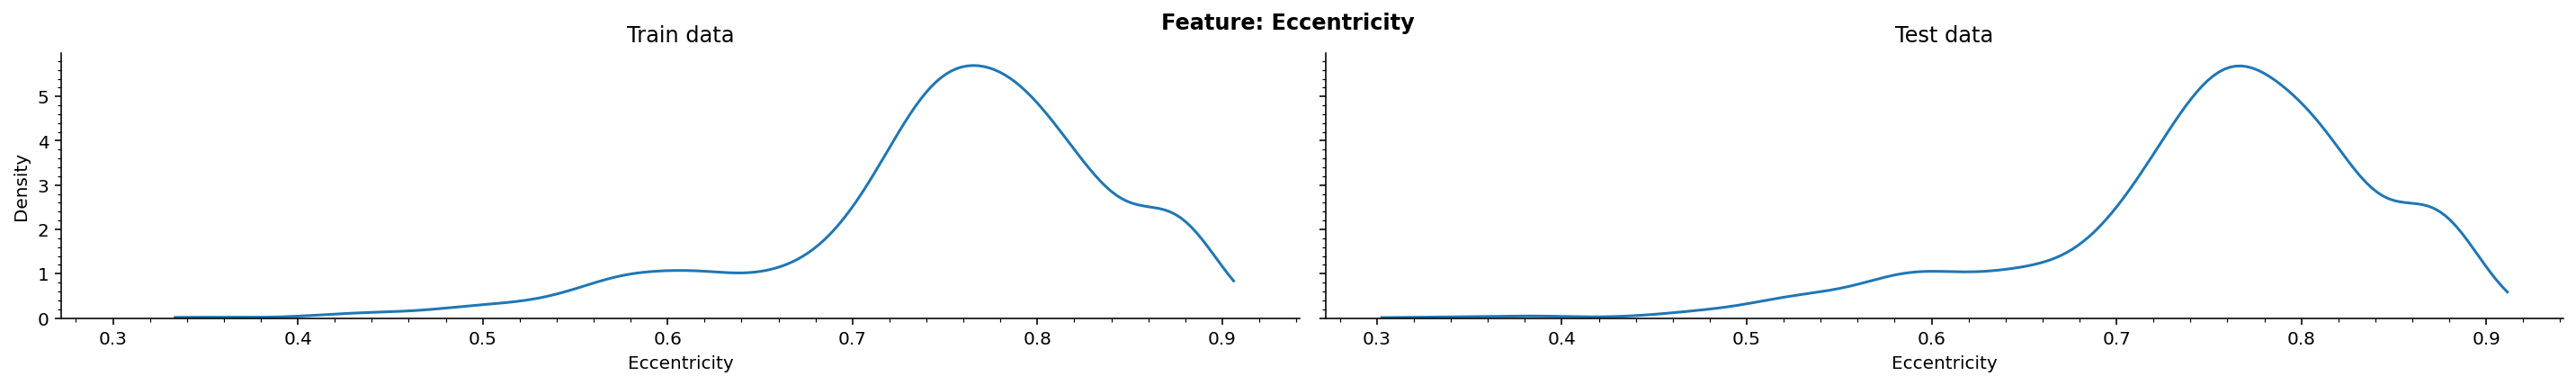


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
BARBUNYA,252.0,0.7606,0.0453,0.5666,0.7356,0.7667,0.7958,0.8586
BOMBAY,103.0,0.7676,0.0424,0.5910,0.7370,0.7744,0.7959,0.8453
CALI,276.0,0.8147,0.0249,0.6370,0.8009,0.8180,0.8311,0.8626
DERMASON,654.0,0.7377,0.0399,0.5779,0.7151,0.7403,0.7649,0.8327
HOROZ,361.0,0.8670,0.0223,0.7582,0.8580,0.8716,0.8821,0.9061
SEKER,374.0,0.5868,0.0698,0.3337,0.5526,0.5904,0.6266,0.7686
SIRA,480.0,0.7645,0.0337,0.6078,0.7436,0.7664,0.7871,0.8421


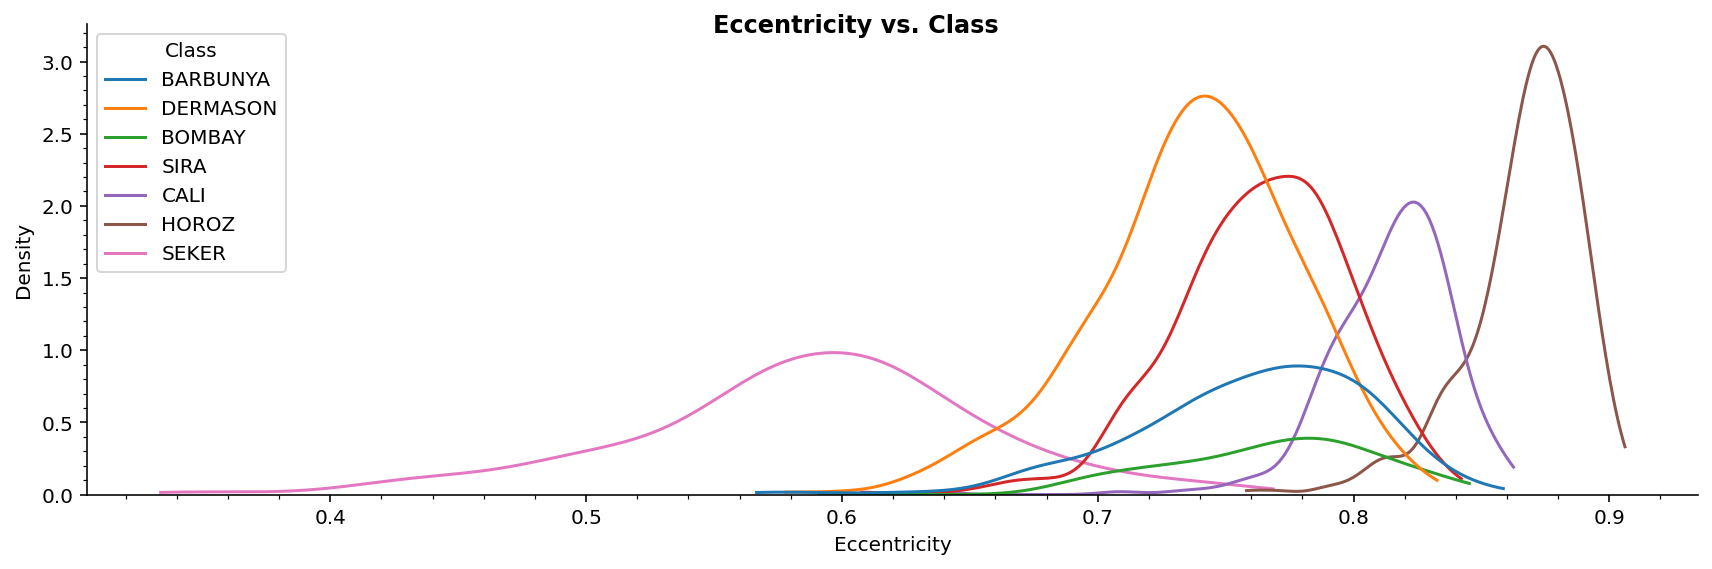

In [24]:
explore_cont('Eccentricity')

**ConvexArea**


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,2500.0,54038.3964,30616.3605,21590.0,36788.75,45288.0,61951.00,263261.0
Test,2500.0,54012.3168,30034.0540,20988.0,36825.50,45427.0,61607.75,244319.0


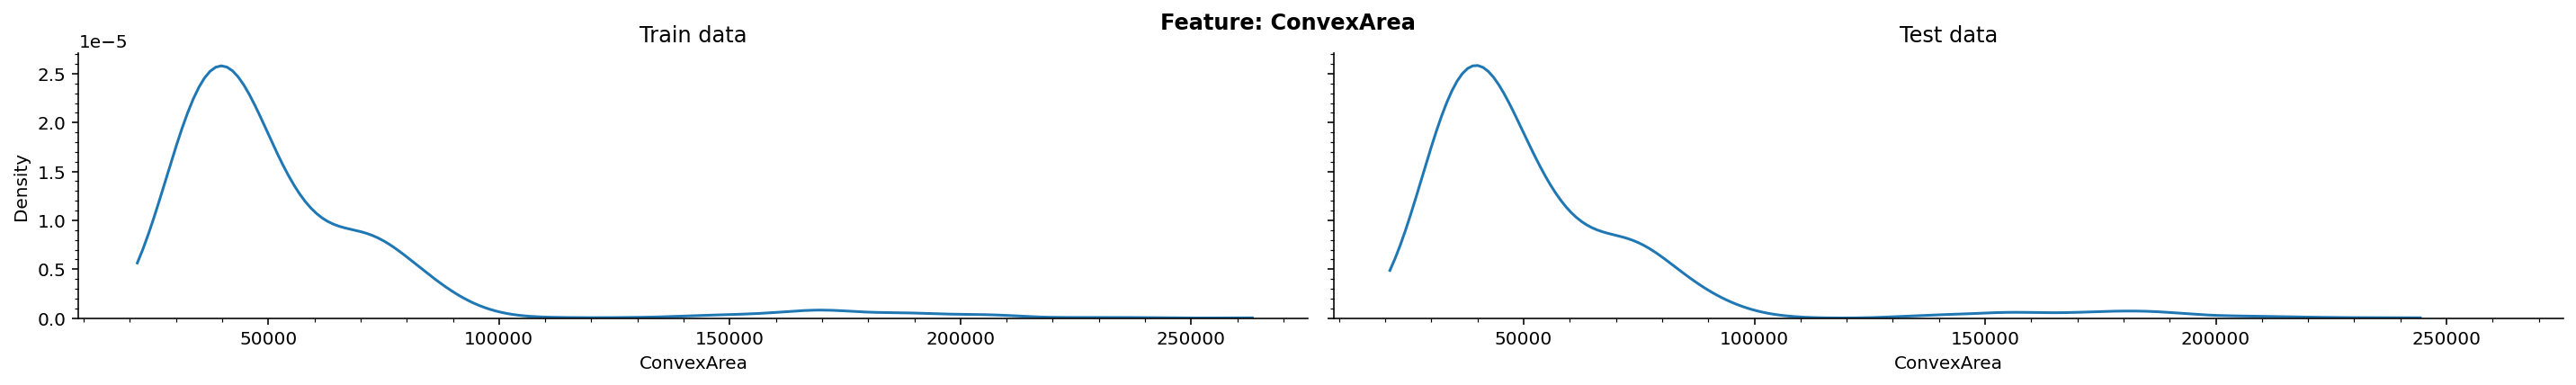


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
BARBUNYA,252.0,70828.8294,10483.1576,42483.0,63325.00,70740.5,77353.00,100632.0
BOMBAY,103.0,177237.0874,24483.1638,115298.0,162090.00,172608.0,192034.50,263261.0
CALI,276.0,76304.4891,9006.3077,46074.0,70780.25,75584.5,82610.50,110337.0
DERMASON,654.0,32556.2538,4580.2707,21590.0,29242.00,32196.5,35951.00,42508.0
HOROZ,361.0,54781.2687,7382.4931,36088.0,49603.00,55014.0,59516.00,73210.0
SEKER,374.0,40271.3262,4696.7077,30417.0,36890.75,39514.5,43402.75,58461.0
SIRA,480.0,45421.5896,4603.1857,33564.0,42457.50,45250.0,48205.50,58490.0


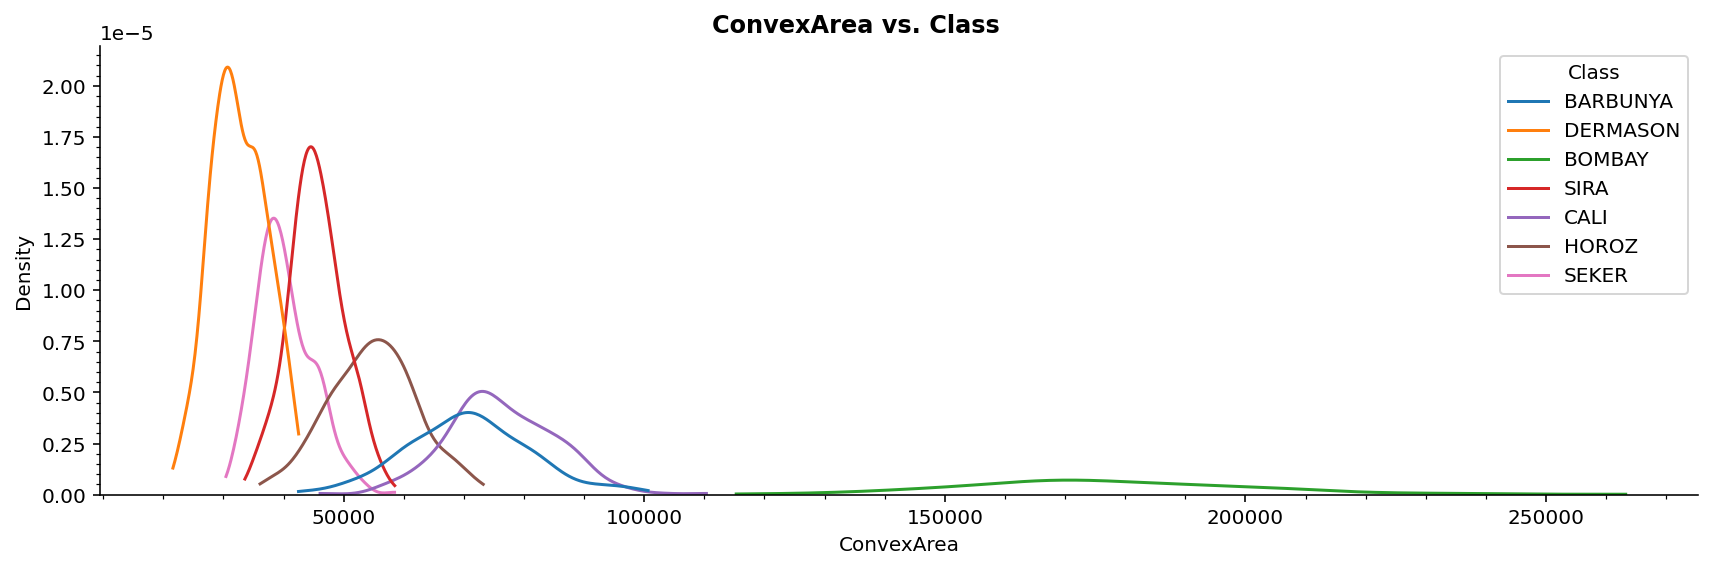

In [25]:
explore_cont('ConvexArea')

**EquivDiameter**


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,2500.0,253.4905,60.2090,164.8670,215.3335,238.7022,278.7548,569.3744
Test,2500.0,253.5625,59.6464,162.3886,215.4067,239.0220,278.2828,554.3110


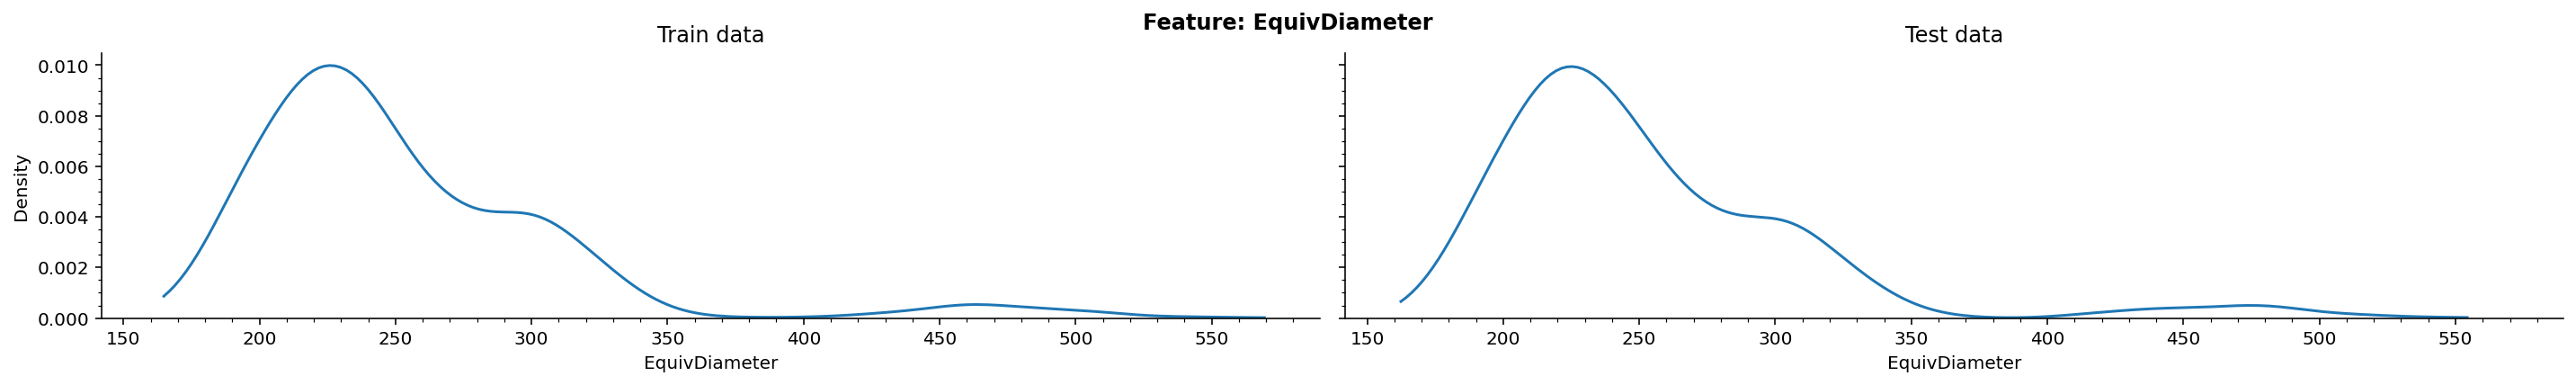


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
BARBUNYA,252.0,296.8748,22.0975,229.8323,281.9057,297.4975,311.5624,353.7374
BOMBAY,103.0,470.8748,32.0352,380.9913,451.7763,466.6472,489.9008,569.3744
CALI,276.0,308.8269,18.2585,241.1302,297.6810,307.8925,322.4229,370.6704
DERMASON,654.0,201.9078,14.3590,164.8670,191.6086,201.3216,212.7271,231.5158
HOROZ,361.0,261.4946,17.7592,212.4951,248.8837,262.5271,273.2589,302.8011
SEKER,374.0,224.9877,12.9832,195.8965,215.7868,223.2124,234.0597,271.7356
SIRA,480.0,238.7184,12.1346,205.5385,231.0816,238.5501,246.4288,270.4252


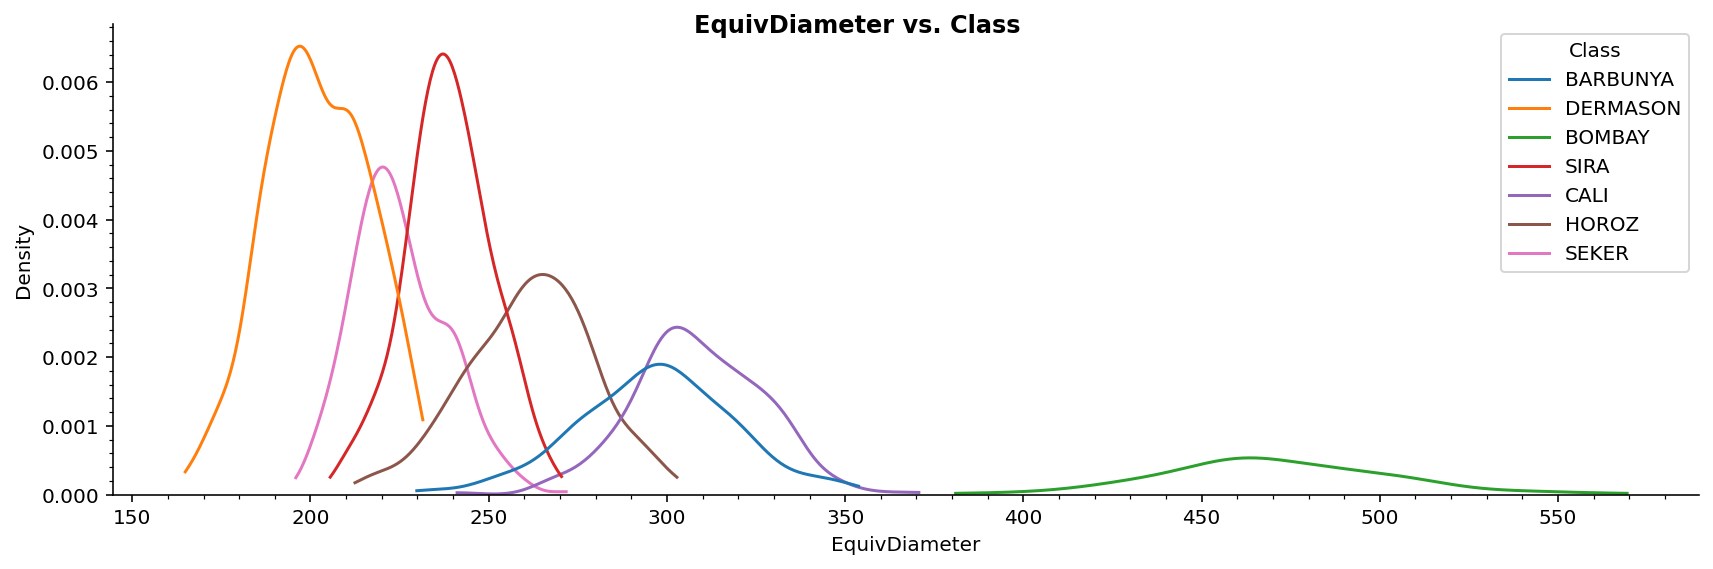

In [26]:
explore_cont('EquivDiameter')

**Extent**


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,2500.0,0.7493,0.0496,0.5667,0.7193,0.7595,0.7862,0.8528
Test,2500.0,0.7506,0.0486,0.5702,0.7196,0.7607,0.7872,0.8584


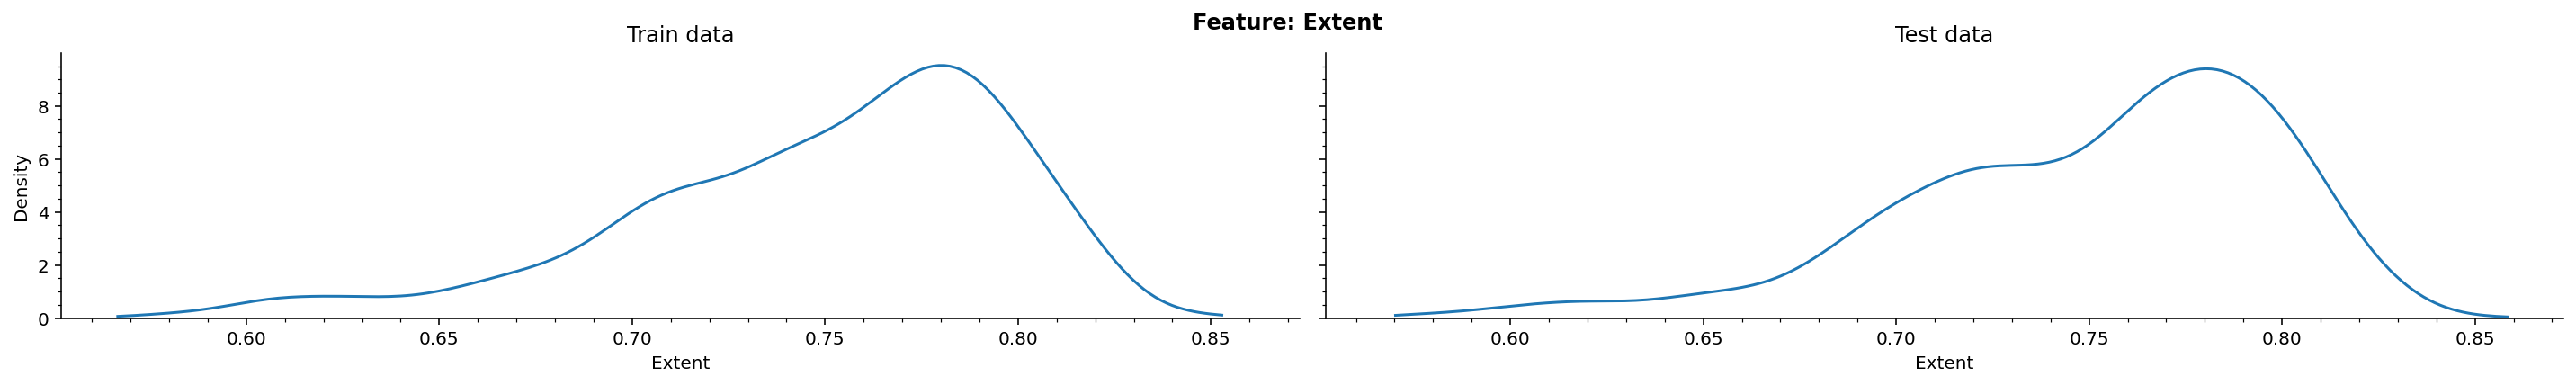


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
BARBUNYA,252.0,0.7466,0.0413,0.6429,0.7151,0.7466,0.7797,0.8406
BOMBAY,103.0,0.7725,0.0394,0.6620,0.7456,0.7815,0.8010,0.8486
CALI,276.0,0.7593,0.0422,0.6329,0.7357,0.7658,0.7913,0.8348
DERMASON,654.0,0.7533,0.0366,0.6614,0.7240,0.7558,0.7830,0.8528
HOROZ,361.0,0.7005,0.0740,0.5667,0.6342,0.6943,0.7676,0.8507
SEKER,374.0,0.7730,0.0186,0.6838,0.7616,0.7761,0.7857,0.8240
SIRA,480.0,0.7527,0.0441,0.6559,0.7141,0.7568,0.7918,0.8339


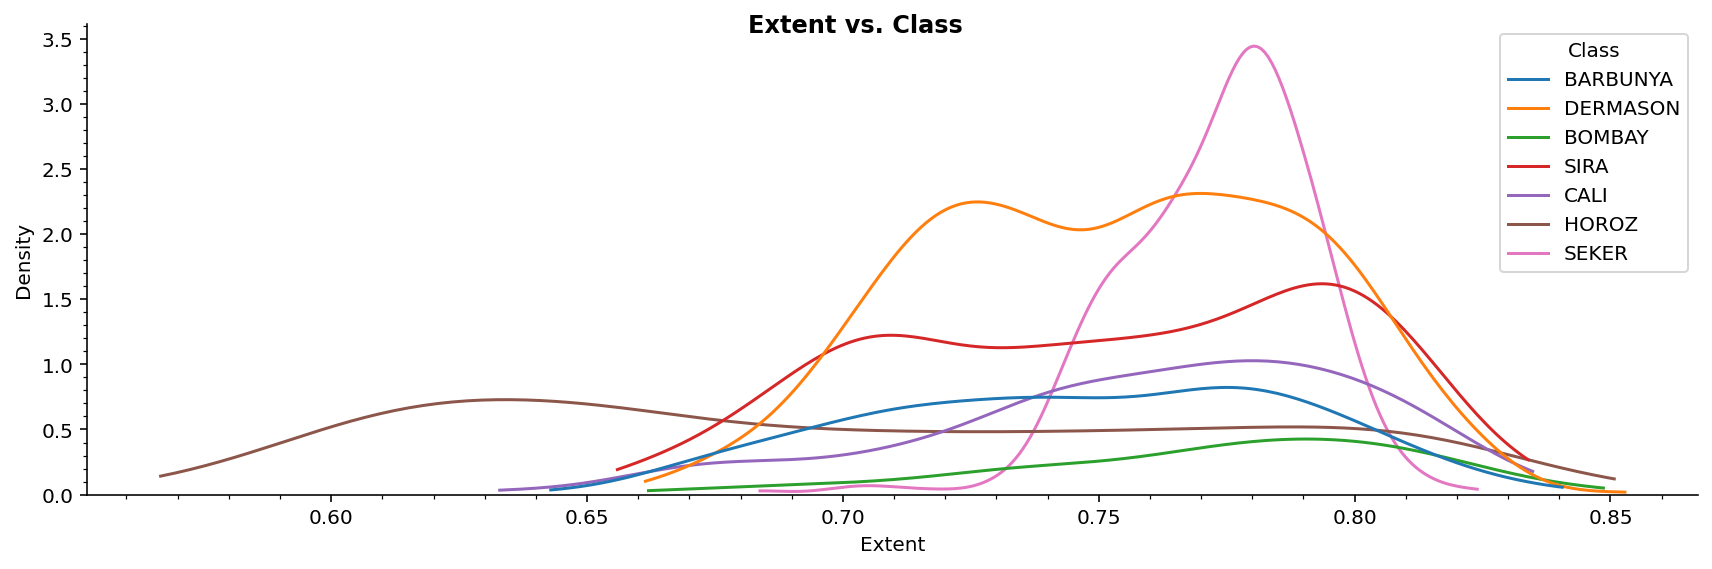

In [27]:
explore_cont('Extent')

**Solidity**


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,2500.0,0.9871,0.0046,0.9490,0.9856,0.9883,0.9899,0.9938
Test,2500.0,0.9871,0.0048,0.9436,0.9856,0.9882,0.9900,0.9947


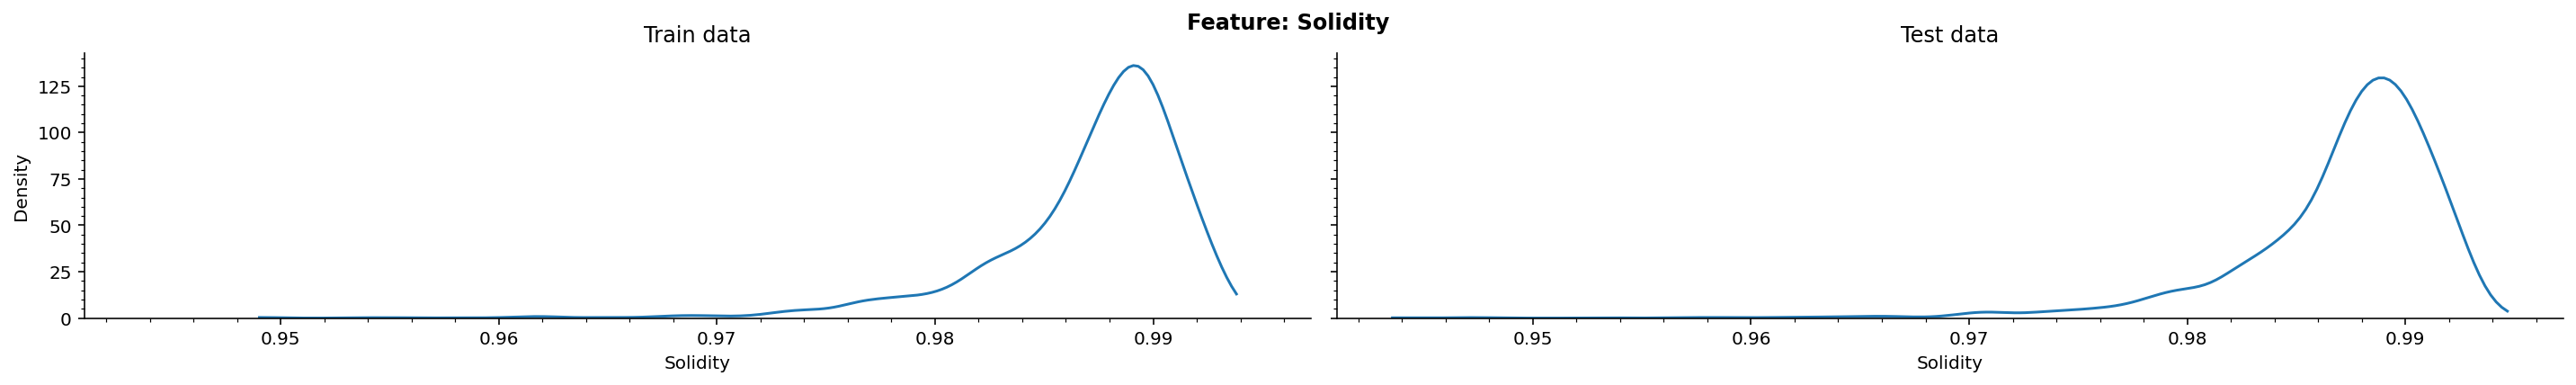


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
BARBUNYA,252.0,0.9827,0.0045,0.9618,0.9807,0.9830,0.9854,0.9925
BOMBAY,103.0,0.9872,0.0047,0.9647,0.9854,0.9884,0.9903,0.9936
CALI,276.0,0.9851,0.0056,0.9607,0.9817,0.9868,0.9894,0.9933
DERMASON,654.0,0.9884,0.0026,0.9678,0.9875,0.9887,0.9898,0.9933
HOROZ,361.0,0.9849,0.0062,0.9490,0.9836,0.9866,0.9883,0.9928
SEKER,374.0,0.9905,0.0025,0.9719,0.9894,0.9910,0.9920,0.9938
SIRA,480.0,0.9879,0.0027,0.9770,0.9867,0.9884,0.9898,0.9927


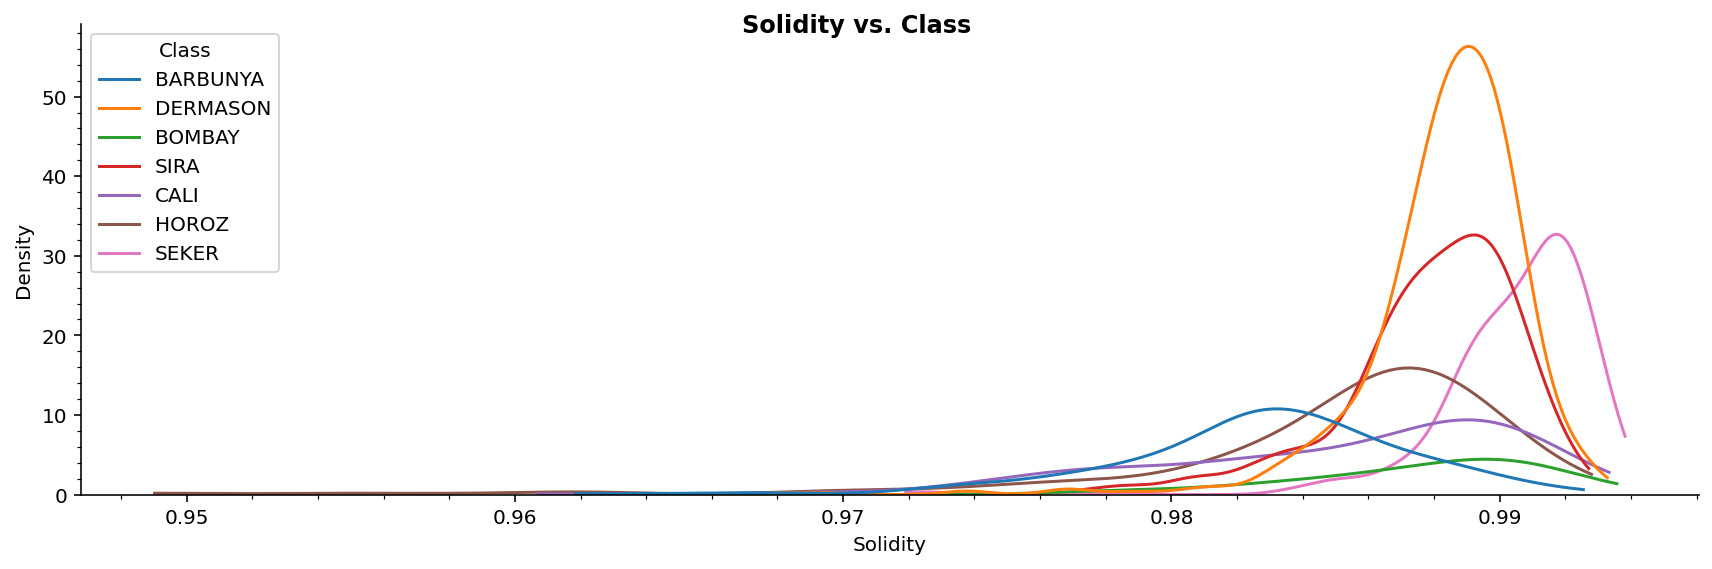

In [28]:
explore_cont('Solidity')

**roundness**


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,2500.0,0.8732,0.0605,0.5568,0.8314,0.8835,0.9173,0.9867
Test,2500.0,0.8728,0.0595,0.5778,0.8320,0.8825,0.9167,0.9907


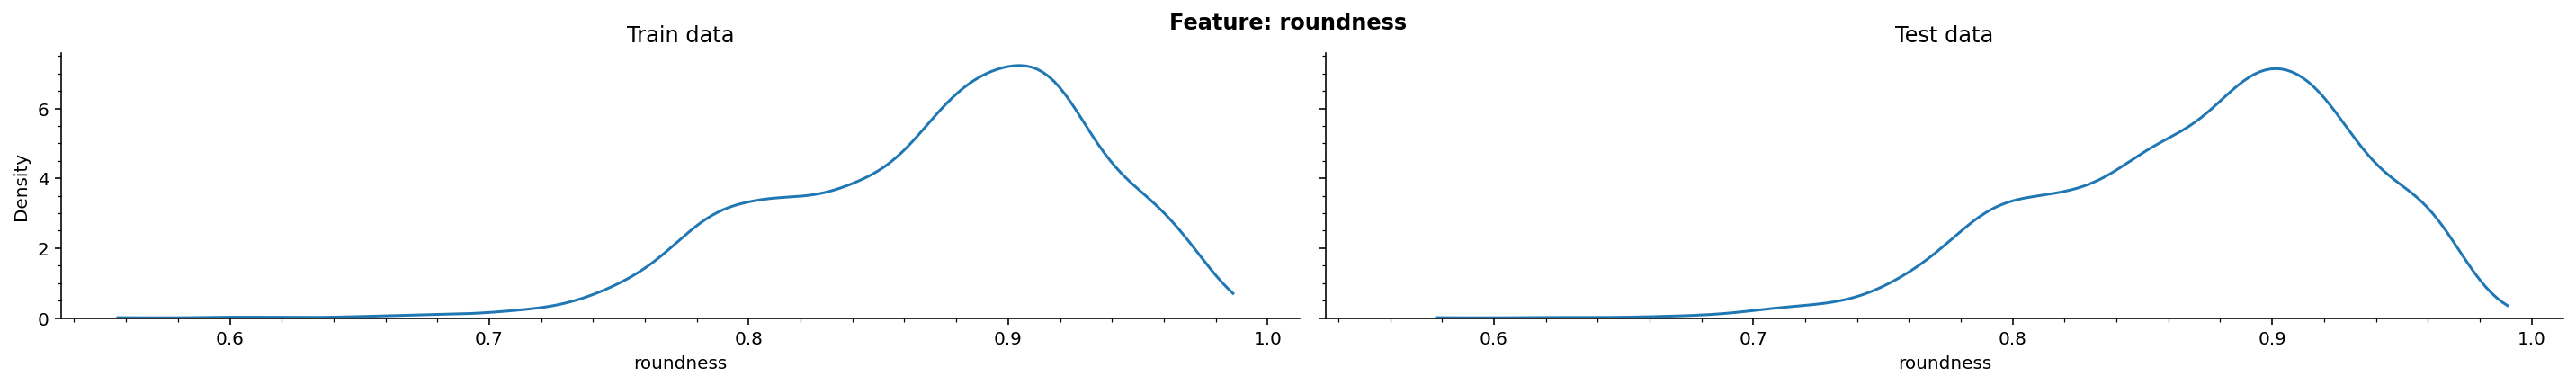


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
BARBUNYA,252.0,0.7992,0.0504,0.6054,0.7752,0.7997,0.8353,0.9026
BOMBAY,103.0,0.8656,0.0258,0.7996,0.8471,0.8668,0.8813,0.9406
CALI,276.0,0.8454,0.0235,0.7666,0.8300,0.8448,0.8620,0.9200
DERMASON,654.0,0.9088,0.0265,0.7342,0.8965,0.9128,0.9248,0.9644
HOROZ,361.0,0.7919,0.0319,0.5568,0.7763,0.7938,0.8107,0.8791
SEKER,374.0,0.9449,0.0334,0.5950,0.9362,0.9514,0.9644,0.9867
SIRA,480.0,0.8862,0.0222,0.7372,0.8723,0.8871,0.9008,0.9461


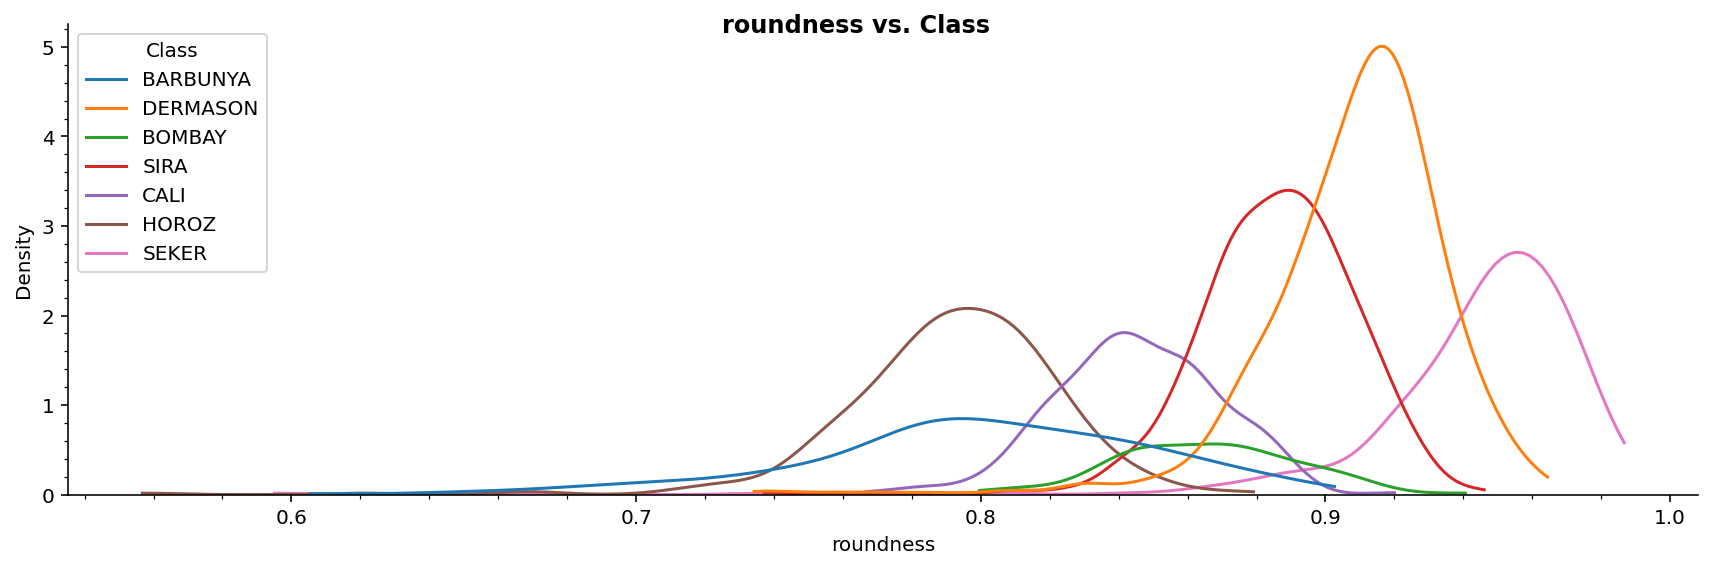

In [29]:
explore_cont('roundness')

**Compactness**


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,2500.0,0.7999,0.0616,0.6488,0.7635,0.8020,0.8339,0.9705
Test,2500.0,0.7997,0.0618,0.6406,0.7625,0.8011,0.8347,0.9759


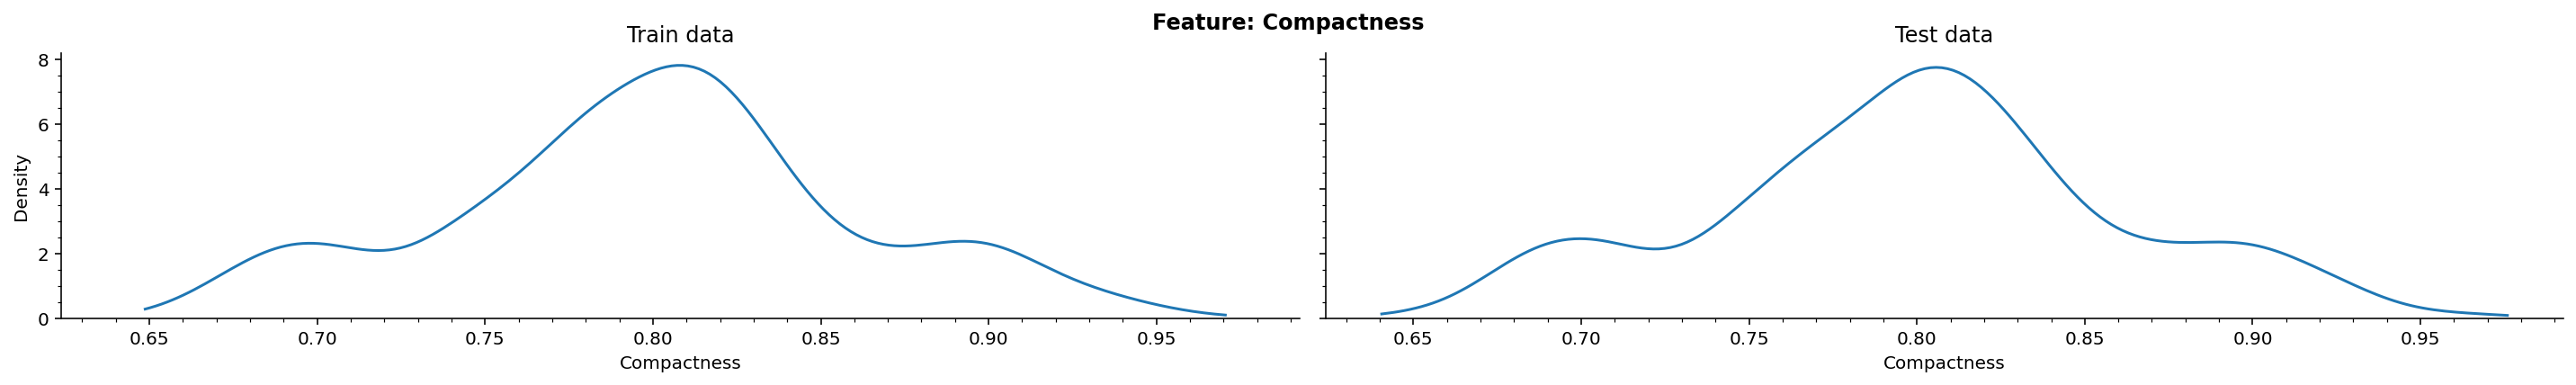


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
BARBUNYA,252.0,0.8012,0.0316,0.7145,0.7768,0.7997,0.8212,0.9042
BOMBAY,103.0,0.7949,0.0314,0.7280,0.7746,0.7934,0.8196,0.8955
CALI,276.0,0.7567,0.0218,0.7065,0.7418,0.7551,0.7703,0.8773
DERMASON,654.0,0.8185,0.0263,0.7429,0.8015,0.8189,0.8345,0.9015
HOROZ,361.0,0.7010,0.0249,0.6488,0.6838,0.6972,0.7139,0.7974
SEKER,374.0,0.8962,0.0282,0.7994,0.8818,0.8978,0.9125,0.9705
SIRA,480.0,0.7992,0.0246,0.7330,0.7832,0.7998,0.8157,0.8895


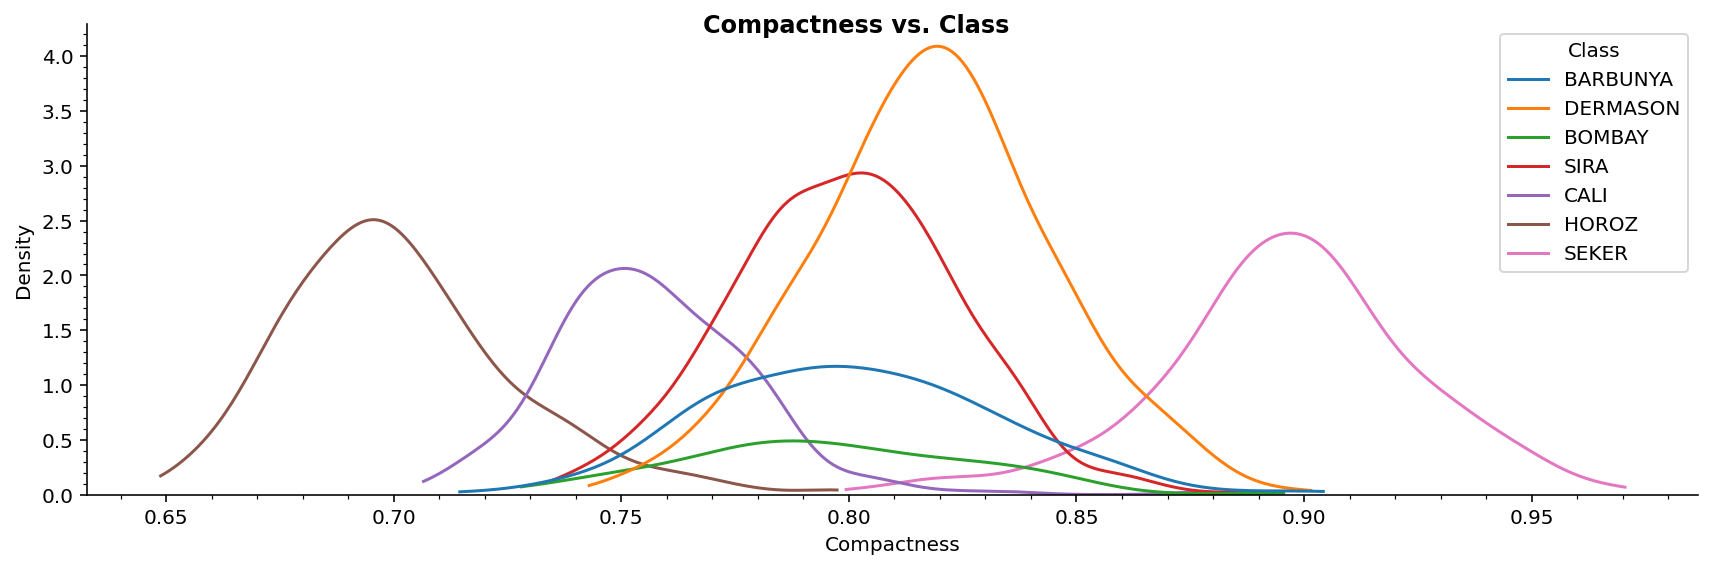

In [30]:
explore_cont('Compactness')

**ShapeFactor1**


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,2500.0,0.0066,0.0011,0.0028,0.0059,0.0066,0.0073,0.0097
Test,2500.0,0.0066,0.0011,0.0029,0.0059,0.0067,0.0073,0.0105


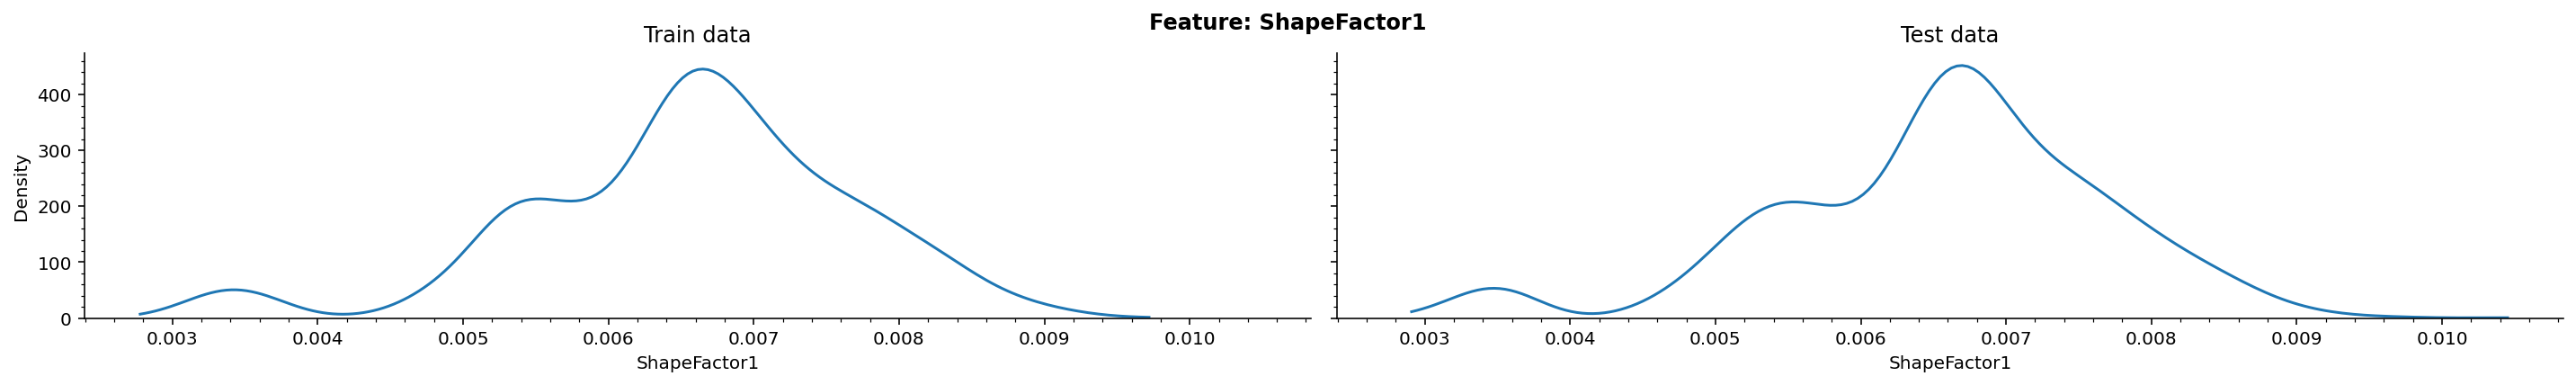


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
BARBUNYA,252.0,0.0054,0.0005,0.0043,0.0051,0.0054,0.0056,0.0072
BOMBAY,103.0,0.0034,0.0002,0.0028,0.0033,0.0034,0.0036,0.0040
CALI,276.0,0.0055,0.0003,0.0046,0.0053,0.0055,0.0057,0.0066
DERMASON,654.0,0.0077,0.0006,0.0064,0.0073,0.0077,0.0081,0.0097
HOROZ,361.0,0.0070,0.0005,0.0054,0.0066,0.0070,0.0073,0.0086
SEKER,374.0,0.0063,0.0003,0.0053,0.0061,0.0064,0.0066,0.0072
SIRA,480.0,0.0067,0.0003,0.0057,0.0065,0.0067,0.0069,0.0077


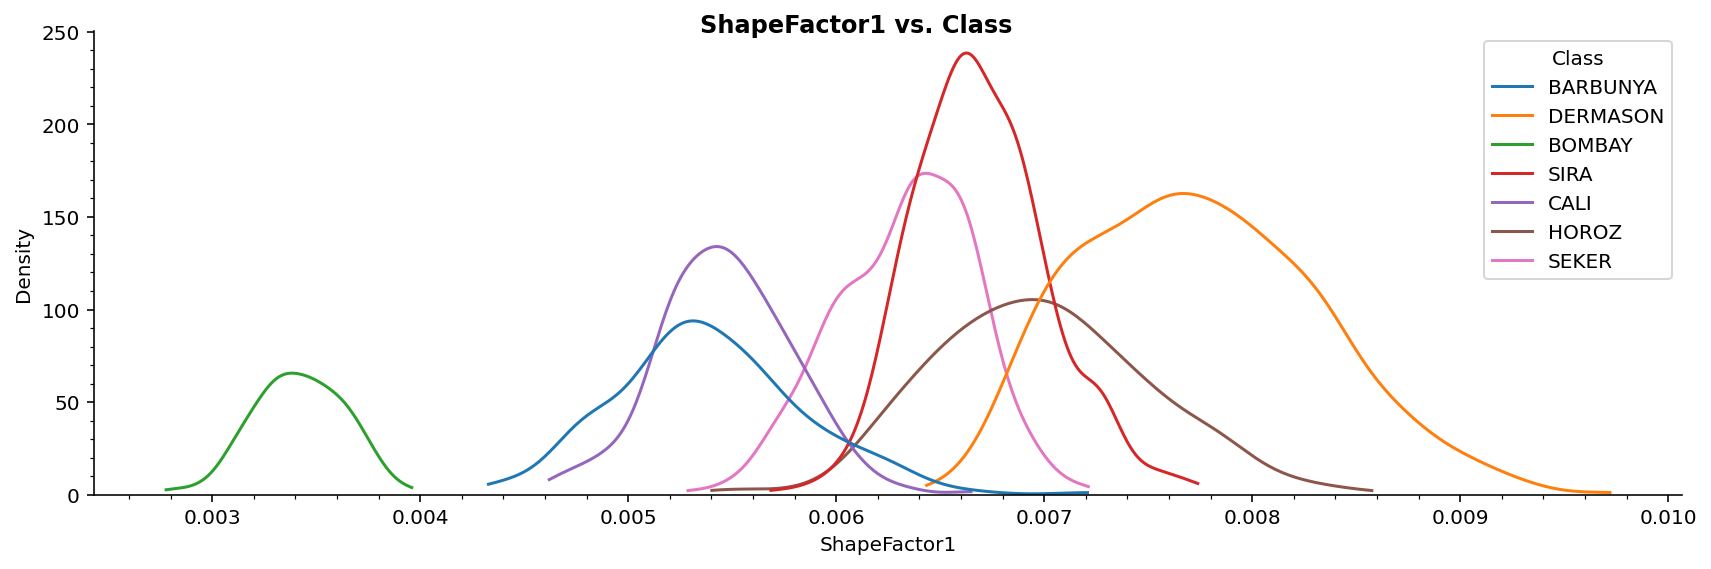

In [31]:
explore_cont('ShapeFactor1')

**ShapeFactor2**


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,2500.0,0.0017,0.0006,0.0006,0.0012,0.0017,0.0022,0.0037
Test,2500.0,0.0017,0.0006,0.0006,0.0012,0.0017,0.0022,0.0036


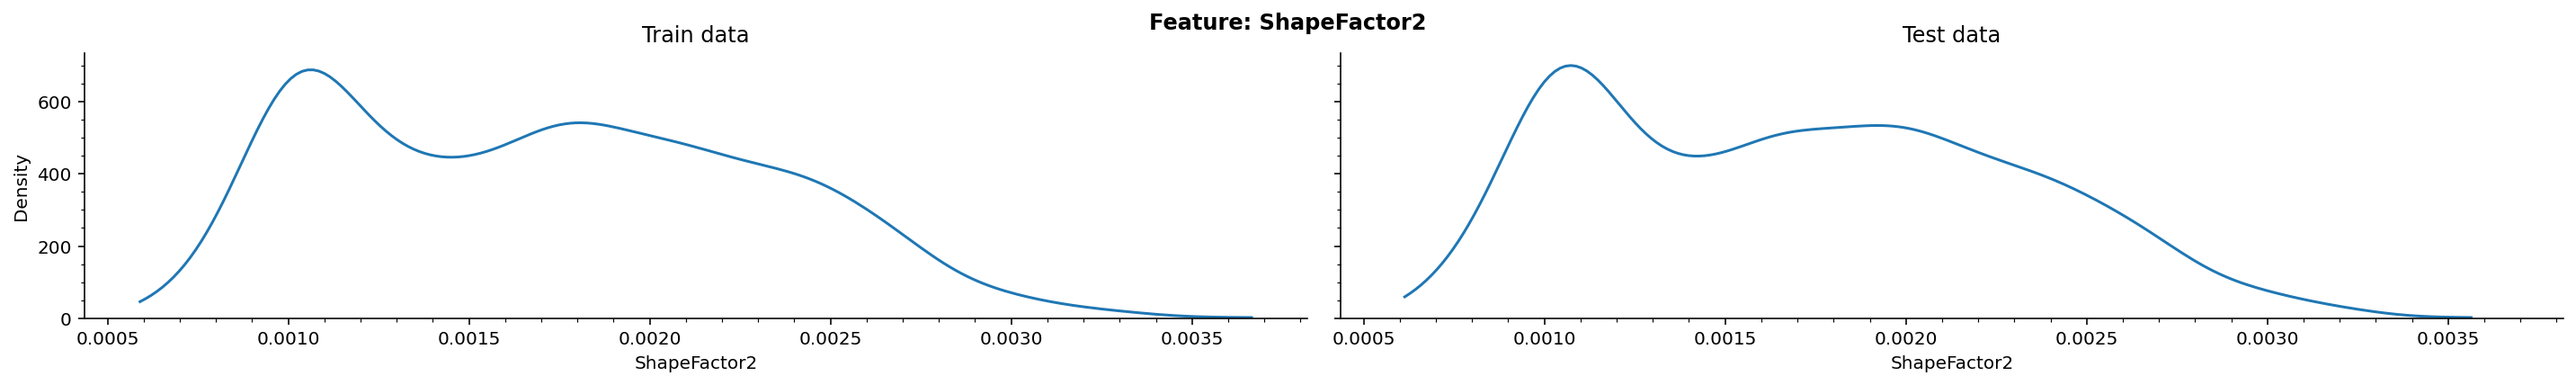


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
BARBUNYA,252.0,0.0014,0.0002,0.0009,0.0012,0.0013,0.0015,0.0021
BOMBAY,103.0,0.0008,0.0001,0.0006,0.0008,0.0008,0.0009,0.0012
CALI,276.0,0.0011,0.0001,0.0009,0.0010,0.0011,0.0012,0.0022
DERMASON,654.0,0.0022,0.0003,0.0015,0.0019,0.0021,0.0023,0.0033
HOROZ,361.0,0.0010,0.0001,0.0008,0.0009,0.0010,0.0011,0.0018
SEKER,374.0,0.0025,0.0003,0.0015,0.0023,0.0025,0.0027,0.0037
SIRA,480.0,0.0017,0.0002,0.0012,0.0015,0.0017,0.0018,0.0025


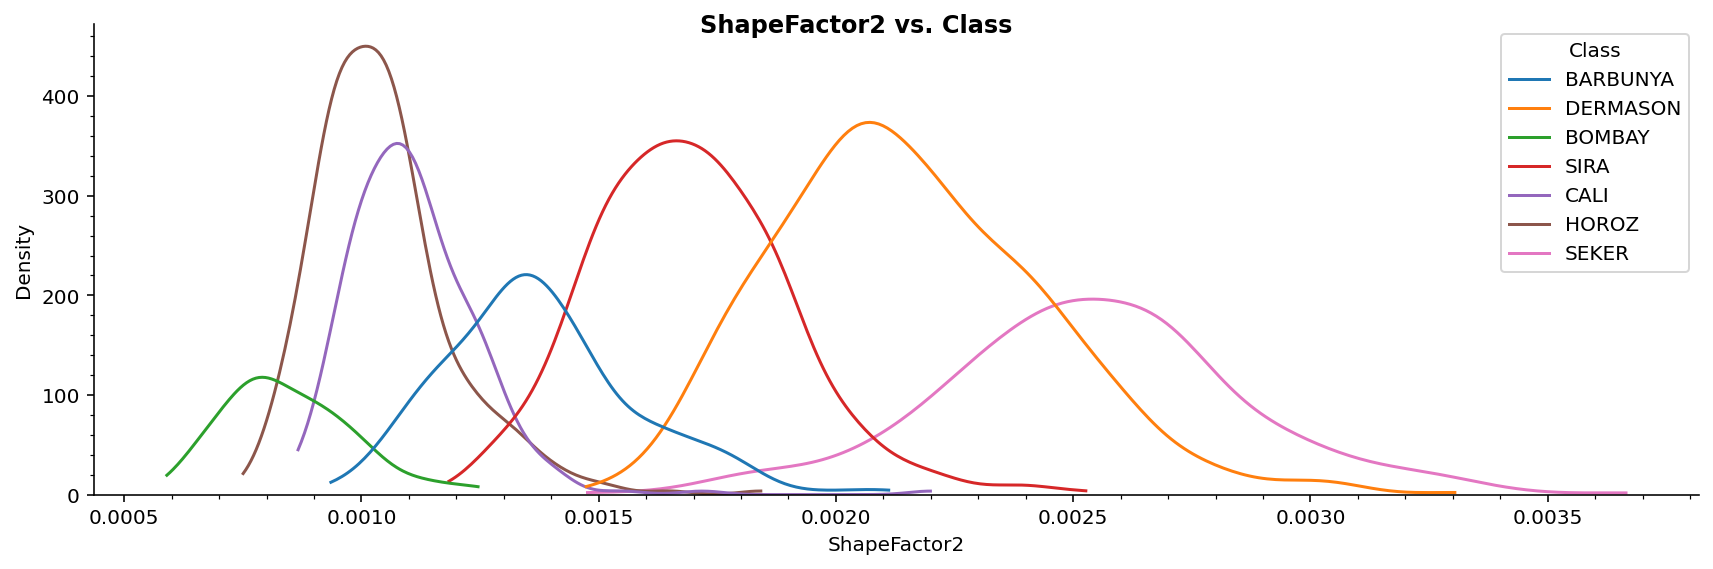

In [32]:
explore_cont('ShapeFactor2')

**ShapeFactor3**


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,2500.0,0.6437,0.0987,0.4209,0.5830,0.6432,0.6954,0.9419
Test,2500.0,0.6434,0.0990,0.4103,0.5814,0.6417,0.6968,0.9524


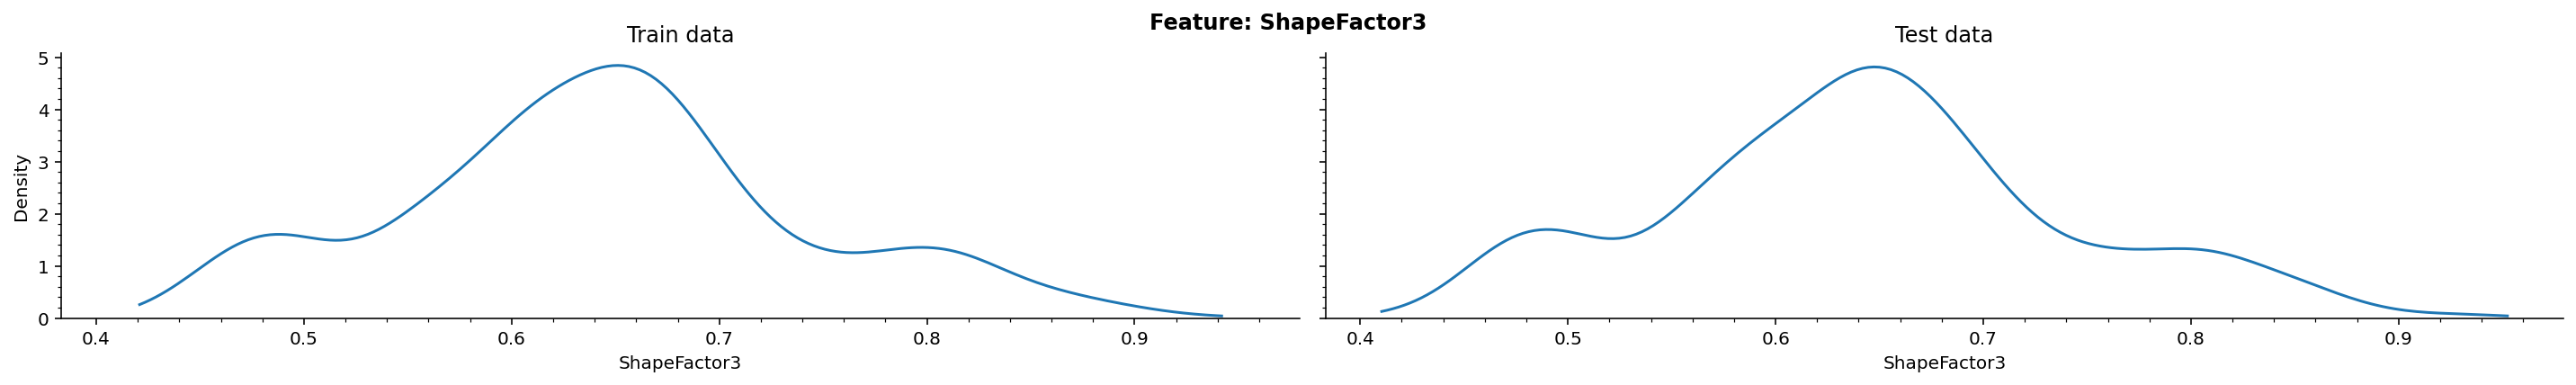


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
BARBUNYA,252.0,0.6429,0.0508,0.5105,0.6035,0.6395,0.6743,0.8176
BOMBAY,103.0,0.6328,0.0501,0.5300,0.6000,0.6295,0.6717,0.8020
CALI,276.0,0.5731,0.0335,0.4992,0.5502,0.5702,0.5933,0.7696
DERMASON,654.0,0.6706,0.0431,0.5519,0.6424,0.6705,0.6964,0.8127
HOROZ,361.0,0.4921,0.0354,0.4209,0.4675,0.4861,0.5097,0.6358
SEKER,374.0,0.8039,0.0503,0.6390,0.7776,0.8060,0.8326,0.9419
SIRA,480.0,0.6394,0.0394,0.5373,0.6135,0.6396,0.6654,0.7913


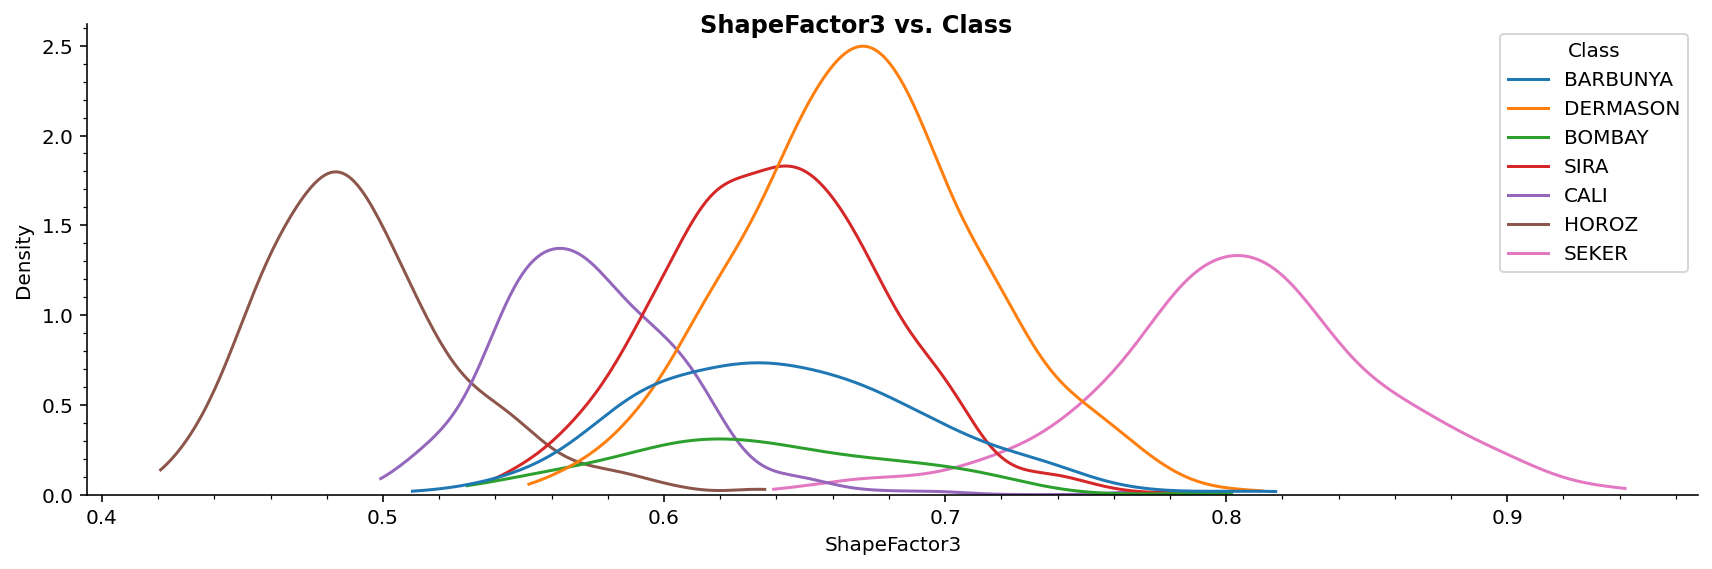

In [33]:
explore_cont('ShapeFactor3')

**ShapeFactor4**


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,2500.0,0.995,0.0045,0.9500,0.9937,0.9964,0.9980,0.9997
Test,2500.0,0.995,0.0045,0.9512,0.9936,0.9964,0.9979,0.9996


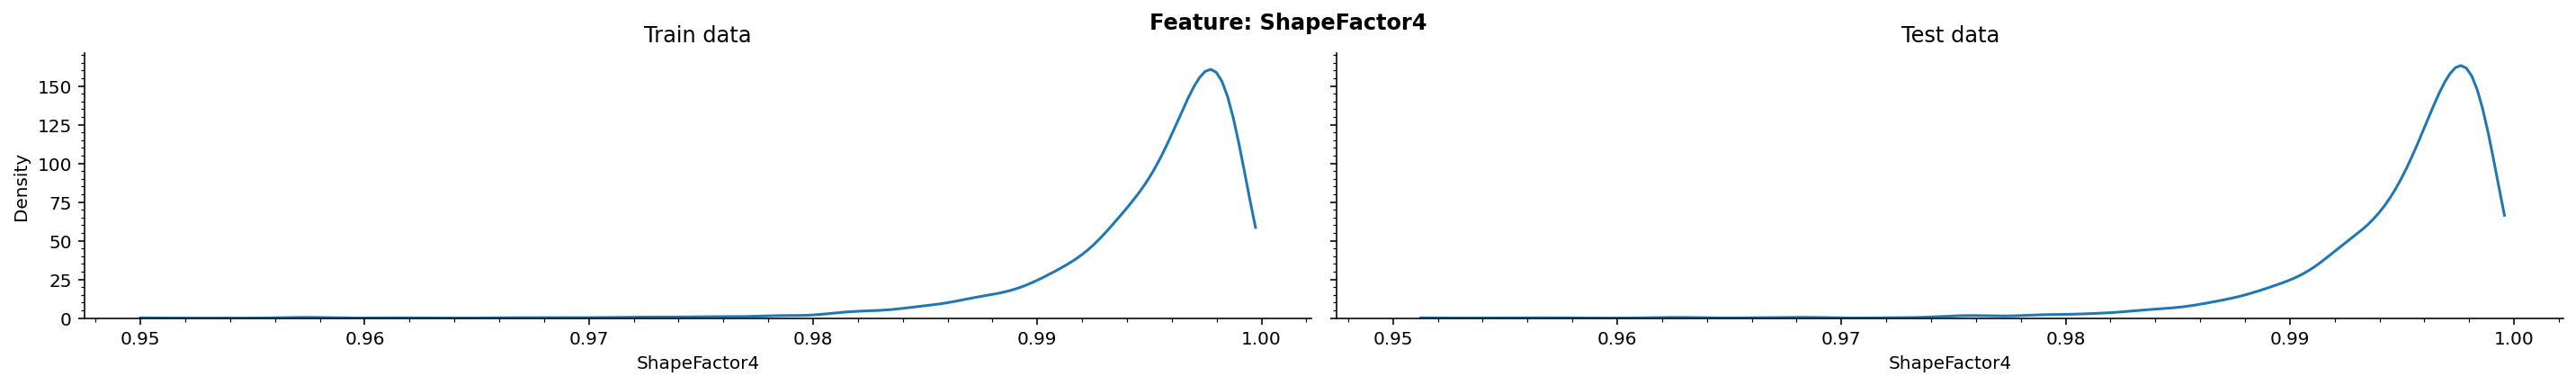


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
BARBUNYA,252.0,0.9957,0.0030,0.9780,0.9948,0.9967,0.9977,0.9989
BOMBAY,103.0,0.9922,0.0041,0.9774,0.9906,0.9925,0.9953,0.9981
CALI,276.0,0.9908,0.0043,0.9728,0.9881,0.9916,0.9939,0.9990
DERMASON,654.0,0.9970,0.0019,0.9788,0.9964,0.9975,0.9981,0.9995
HOROZ,361.0,0.9914,0.0070,0.9500,0.9898,0.9937,0.9957,0.9988
SEKER,374.0,0.9985,0.0009,0.9932,0.9982,0.9987,0.9990,0.9997
SIRA,480.0,0.9951,0.0027,0.9840,0.9938,0.9956,0.9970,0.9995


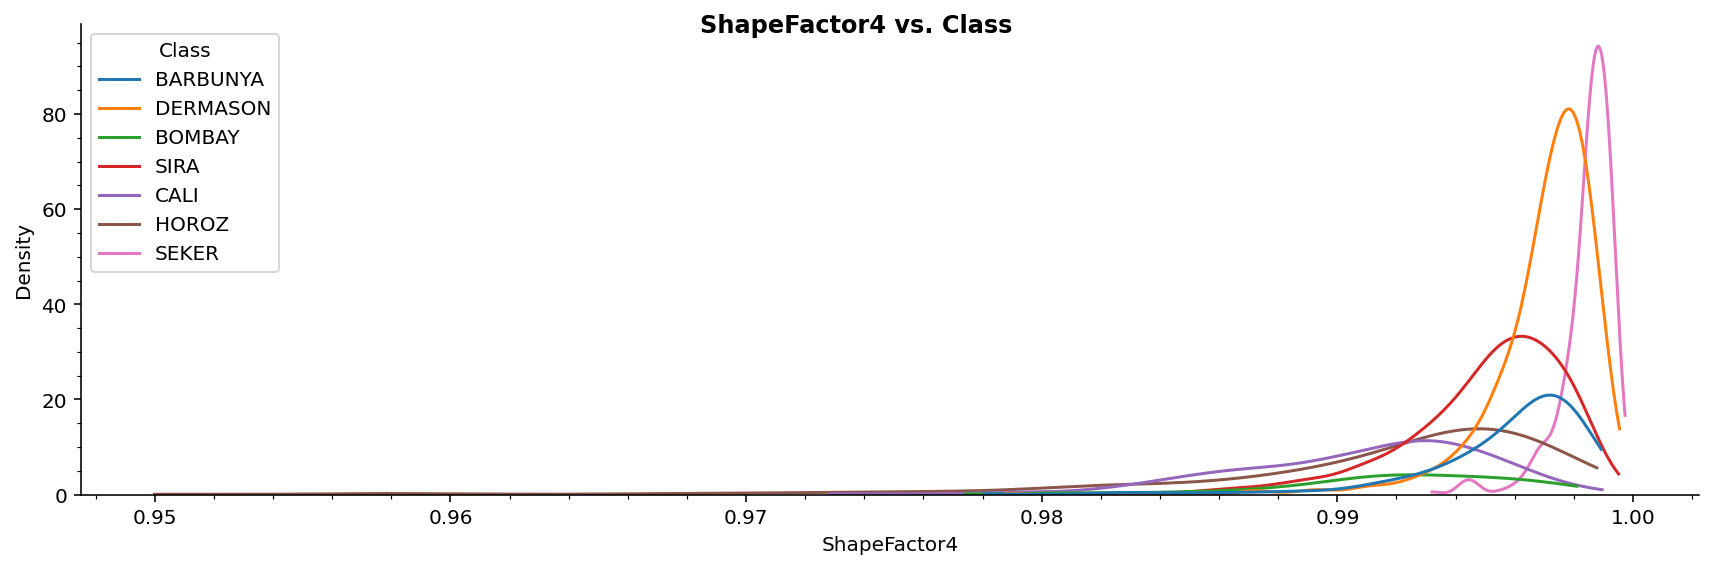

In [34]:
explore_cont('ShapeFactor4')

# Feature selection

In [38]:
features = list(test.columns)

In [48]:
labels = LabelEncoder()
train[TARGET] = labels.fit_transform(train[TARGET])

### Pearson correlation

In [49]:
def plot_corr_matrix(corr_df, size=12):
    plt.figure(figsize=(size, size))
    sns.heatmap(corr_df,
                mask=np.triu(np.ones_like(corr_df)),
                vmin=-1, vmax=1, center=0, 
                annot=True, 
                linewidths=0.1)
    plt.show()

In [50]:
corr_df = train.corr()

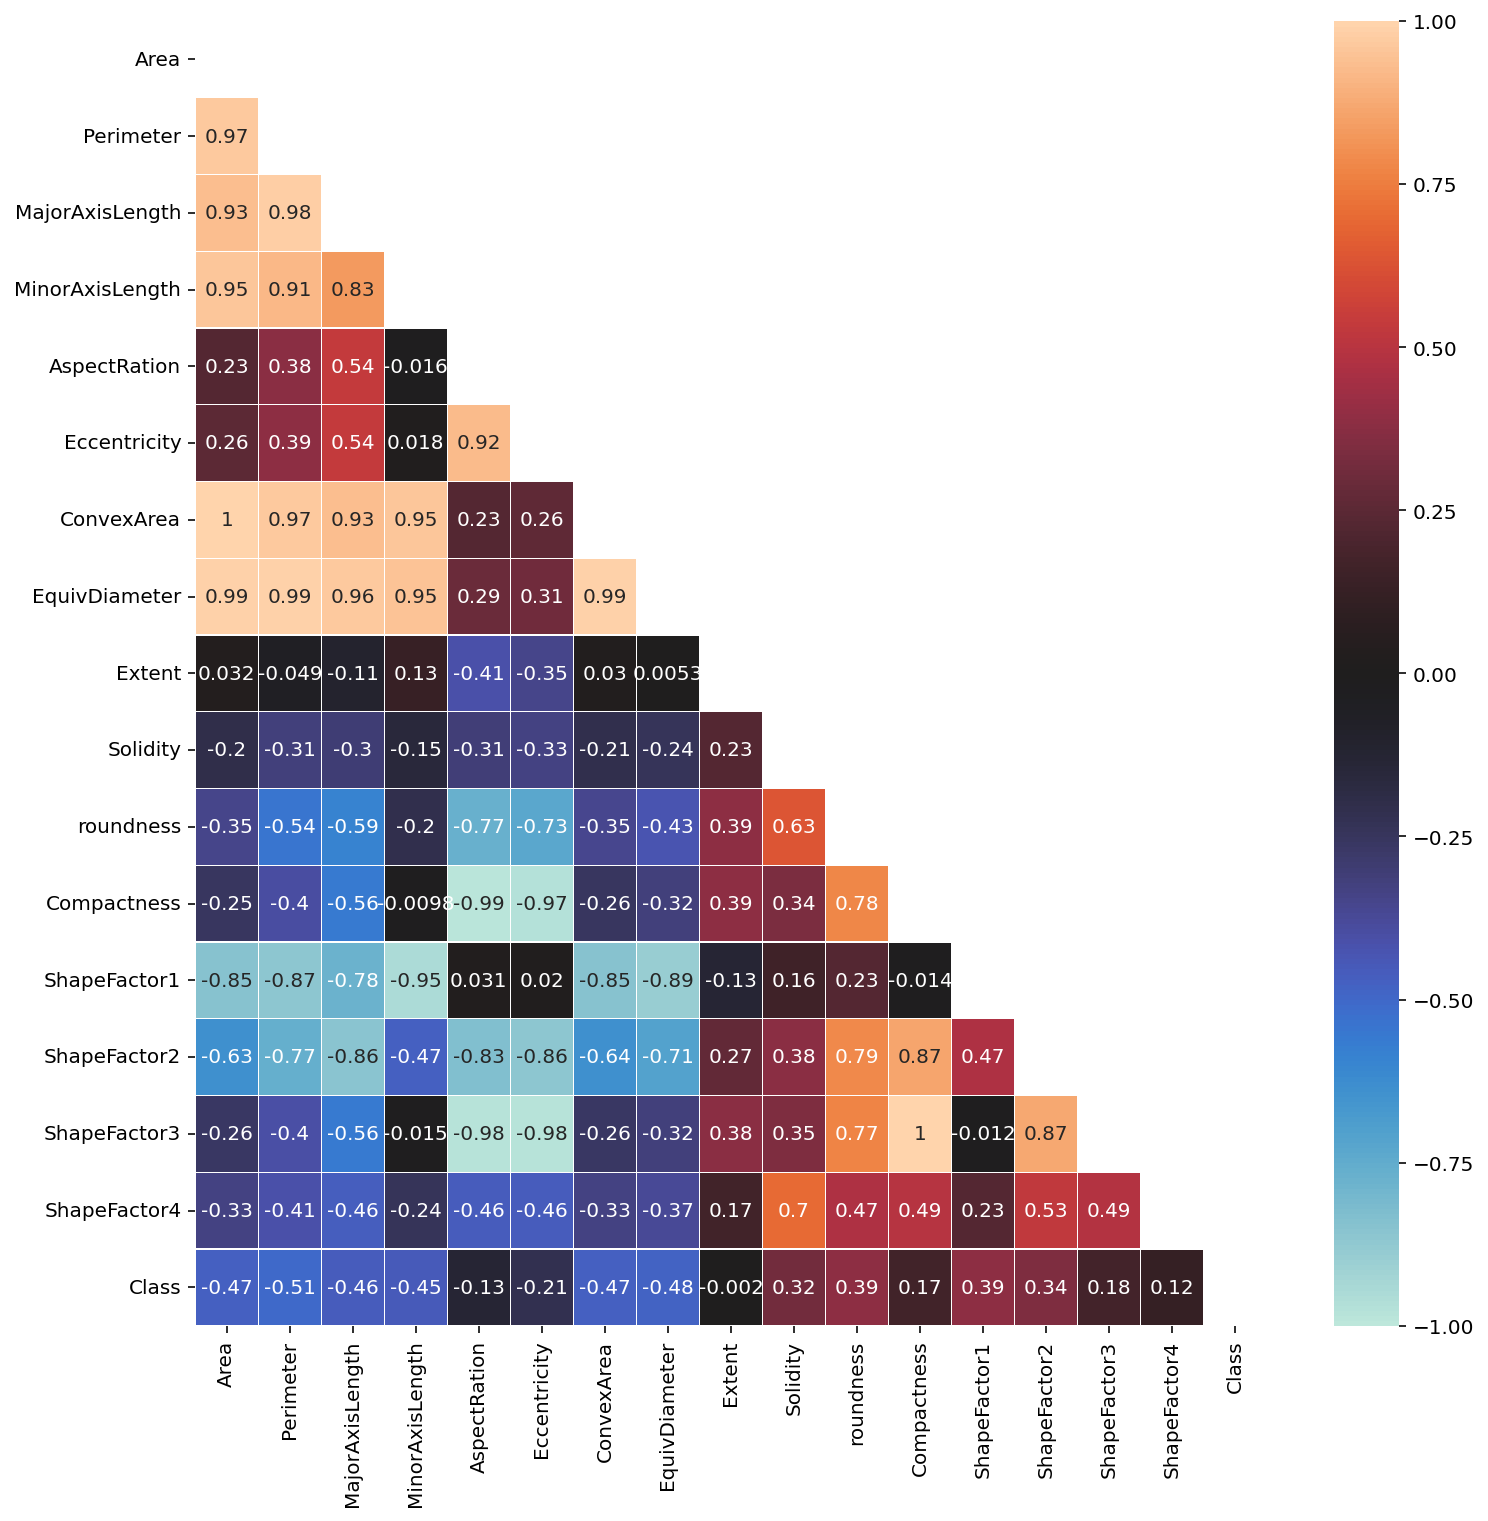

In [51]:
plot_corr_matrix(corr_df)

### ANOVA F-test

In [39]:
anova_test = f_classif(train[features], train[TARGET])

pd.DataFrame(
    data={
        'f-statistic': anova_test[0], 
        'p-value': anova_test[1],
        'accepted?': anova_test[1] < 0.05
    },
    index=features
)

,f-statistic,p-value,accepted?
Area,5606.4995,0.0000e+00,True
Perimeter,4651.1367,0.0000e+00,True
MajorAxisLength,4184.1316,0.0000e+00,True
MinorAxisLength,4299.9963,0.0000e+00,True
AspectRation,1860.0074,0.0000e+00,True
Eccentricity,1522.8408,0.0000e+00,True
ConvexArea,5565.5773,0.0000e+00,True
EquivDiameter,4957.9226,0.0000e+00,True
Extent,97.5840,1.7850e-110,True
Solidity,137.9317,3.2072e-151,True


### Variance Inflation Factor

In [40]:
%%capture
!pip install --upgrade statsmodels==0.13.2
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [44]:
def remove_vif_features(X: pd.DataFrame, threshold: float = 5.0) -> list:
    """Remove feature with highest Variance Inflation Factor
    at every iteration until all remaining features are below
    a certain threshold.
    """
    i = 0
    while True:
        vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
        max_vif = np.max(vif)

        if max_vif <= threshold:
            break

        i += 1
        col_to_remove = X.columns[np.argmax(vif)]
        print(f"Iteration {i:<2}: {col_to_remove:20} ({max_vif:.4f})")
        X.drop(col_to_remove, axis=1, inplace=True)

    if i == 0:
        print(f"No columns removed")
    else:
        print(pd.DataFrame({"Feature": X.columns, "VIF": vif}))

    return list(X.columns)

In [45]:
_ = remove_vif_features(train[features], 5) #rule-of-thumb threshold

Iteration 1 : EquivDiameter        (6032028.4536)
Iteration 2 : Compactness          (1923635.5038)
Iteration 3 : Solidity             (284456.1292)
Iteration 4 : ShapeFactor4         (164322.7024)
Iteration 5 : ConvexArea           (56574.8104)
Iteration 6 : MajorAxisLength      (43319.0472)
Iteration 7 : MinorAxisLength      (25475.4476)
Iteration 8 : Perimeter            (11257.1314)
Iteration 9 : Eccentricity         (1617.1701)
Iteration 10: ShapeFactor3         (853.6217)
Iteration 11: roundness            (489.6804)
Iteration 12: ShapeFactor1         (253.0765)
Iteration 13: Extent               (179.0477)
Iteration 14: AspectRation         (11.0657)
        Feature     VIF
0          Area  2.0778
1  ShapeFactor2  2.0778


### Mutual Information score

In [43]:
mi_scores = mutual_info_classif(train[features], train[TARGET], random_state=SEED)

pd.DataFrame(
    data={'mi_score': mi_scores}, 
    index=features
).T

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
mi_score,1.0423,1.0635,0.992,0.9242,0.8141,0.8143,1.0269,1.0421,0.2046,0.2488,0.8065,0.8034,0.9303,0.9717,0.8035,0.3797


### Feature sets

In [54]:
features = list(test.columns)

reduced_features = ['Area', 'AspectRation', 'Extent', 'Solidity', 
                    'roundness', 'ShapeFactor2', 'ShapeFactor4']

# Modeling

In [136]:
def cross_validate_predict(model, feature_set, n_splits=5):
    oof_preds = {}  #out-of-fold predictions on train set
    test_preds = {} #predictions on test set for each fold
    scores = [] #scores on validation set

    X, y = train[feature_set], train[TARGET]
    X_test = test[feature_set]
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, y_train = X.loc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.loc[val_idx], y.iloc[val_idx]
        
        model.fit(X_train, y_train)

        val_preds = model.predict(X_val)
        oof_preds.update(dict(zip(val_idx, val_preds)))
        test_preds[f'fold{fold}'] = model.predict(X_test)

        score = accuracy_score(y_val, val_preds)
        scores.append(score)
        print(f'Fold #{fold}: {score:.4f}')
        _ = gc.collect()
    print(f'Avg = {np.mean(scores):.4f} +/- {np.std(scores):.4f}\n')
    
    oof_preds = pd.Series(oof_preds).sort_index()
    test_preds = pd.DataFrame.from_dict(test_preds)
    test_preds['mode'] = test_preds.mode(axis=1)[0].astype('int')

    return oof_preds, test_preds

### Model 1: StandardScaler + LogisticRegression

In [137]:
model1 = make_pipeline(
    StandardScaler(), 
    LogisticRegression(
        max_iter=5000,
        C=10,
        solver='saga',
        multi_class='multinomial',
        # class_weight='balanced',
        n_jobs=-1,
        random_state=SEED
    )
)

In [138]:
oof1, preds1 = cross_validate_predict(model1, features)

Fold #0: 0.9300
Fold #1: 0.9040
Fold #2: 0.9120
Fold #3: 0.9220
Fold #4: 0.9180
Avg = 0.9172 +/- 0.0088



In [139]:
oof2, preds2 = cross_validate_predict(model1, reduced_features)

Fold #0: 0.9300
Fold #1: 0.9100
Fold #2: 0.9180
Fold #3: 0.9300
Fold #4: 0.9180
Avg = 0.9212 +/- 0.0078



### Model 2: RandomForestClassifier

In [140]:
model2 = RandomForestClassifier(
    n_estimators=200,
    max_depth=13,
    # class_weight='balanced',
    n_jobs=-1,
    random_state=SEED
)

In [141]:
oof3, preds3 = cross_validate_predict(model2, features)

Fold #0: 0.9160
Fold #1: 0.9100
Fold #2: 0.9300
Fold #3: 0.9200
Fold #4: 0.9020
Avg = 0.9156 +/- 0.0094



In [142]:
oof4, preds4 = cross_validate_predict(model2, reduced_features)

Fold #0: 0.9220
Fold #1: 0.9160
Fold #2: 0.9260
Fold #3: 0.9320
Fold #4: 0.8980
Avg = 0.9188 +/- 0.0116



# Submission files

In [144]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [145]:
SUBMISSION_PATH = f'/content/drive/MyDrive/data_science_competitions/dphi/ds93/submissions'
if not os.path.isdir(SUBMISSION_PATH):
    os.makedirs(SUBMISSION_PATH)

In [146]:
def create_submission_files(test_preds, model_config, path=SUBMISSION_PATH):
    for col in test_preds.columns:
        sub = pd.DataFrame({
            'Class': labels.inverse_transform(test_preds[col])
        })
        sub.to_csv(f'{path}/{model_config}_{col}.csv', index=False)

In [147]:
create_submission_files(preds1, 'lr_all')

In [148]:
create_submission_files(preds2, 'lr_reduced')

In [149]:
create_submission_files(preds3, 'rf_all')

In [150]:
create_submission_files(preds4, 'rf_reduced')

In [154]:
all_preds = pd.concat([preds1, preds2, preds3, preds4], axis=1).mode(axis=1)[0].astype('int').to_frame()

In [156]:
create_submission_files(all_preds, 'all_preds_mode')